# Introduction

## Who Are We?
1. Denise Teh Kai Xin
2. Kaung Htet Wai Yan
3. Nguyen Xuan Nam
4. Tian Zhuoyu

## Problem Statement

There is a growing need for sentiment analysis for businesses and product owners, given the growing volumes of text-based feedback data.

## Proposed Solution

Analyse the effectivenes of machine learing models on sentiment analysis, and output a model / an ensemble of models to help predict the sentiment of any given text.

## Models used

Non-Deep Learning:
*   Decision Tree [Base]
*   Random Forest
*   Support Vector Classification (SVC)
*   Naive Bayes
*   Ada Boost
*   XGBoost

Deep Learning:
*   Sequential [Base]
*   Dense + Dropout
*   Convolutional Neural Network  (CNN)
*   Biderectional Neural Network
*   LSTM with Attention Mechanism
*   Attention Model with Review Length
*   Transformer Architecture

Other Models:
*   Vader Sentiment Analyser
*   pysentimiento

## Prerequisites

1. Create a new virtual environment. Ensure you are using Python 3.10.
2. Install project dependencies with `pip install -r requirements.txt`.

In [1]:
import pandas as pd
import numpy as np

# Truncate Data

We then group the data by review score, which is either 1 (positive) or -1 (negative). As the data has 6.4 million rows, we truncated the data by randomly sampling 200000 rows, stratified by review score.

In [2]:
def truncate(df: pd.DataFrame, target_col: str, n: int) -> pd.DataFrame:
    return df.groupby(target_col).apply(lambda x: x.sample(n=n//2)).droplevel(0)

def df_to_csv(df:pd.DataFrame, path:str):
    import csv
    df.to_csv(path, index=False, quoting=csv.QUOTE_NONNUMERIC)

# df = pd.read_csv('datasets/steam_dataset.csv')
# df = truncate(df, 'review_score', 200000)
# df_to_csv(df, 'datasets/steam_dataset_200000.csv')

# Clean Data

We convert all text to lowercase, remove non-ASCII characters and punctuation, remove all NA values and tokenizes the text.

In [3]:
def read_data_from_csv(file_path, column_text, column_score):
    """
    Read data from csv file. Select only the columns that are needed.

    Args:
    file_path: string
    column_text: string
    column_score: string
    """
    data = pd.read_csv(file_path)
    data[column_text] = data[column_text].astype(str)
    data[column_score] = data[column_score].astype(int)
    return data

def preprocess(text):
    """
    Preprocess text: Convert a sentence into a tokenised list of words.

    Args:
    text: string
    """
    from nltk.tokenize import word_tokenize
    import string
    # Convert text to lowercase
    text = text.lower()
    # Remove non-ascii characters and punctuation
    text = ''.join([word if (word not in string.punctuation or word.isascii()) else ' ' for word in text])
    # Tokenize text
    tokens = word_tokenize(text)
    return tokens

def clean_data(data, column_text, column_score, new_column_text='text', new_column_score='score'):
    """
    Clean data: Preprocess text and remove rows with missing values. Change column names.

    Args:
    data: pandas dataframe
    column_text: string
    column_score: string
    new_column_text: string
    new_column_score: string
    """

    data[column_text] = data[column_text].apply(preprocess)
    data = data.dropna()
    data = data[[column_text, column_score]]
    data = data.rename(columns={column_text: new_column_text, column_score: new_column_score})
    return data

# df = read_data_from_csv('datasets/steam_dataset_200000.csv', 'review_text', 'review_score')
# df = clean_data(df, 'review_text', 'review_score')
# df_to_csv(df, 'datasets/steam_200000_cleaned.csv')

# Stemming

We change all words into their root form, we apply this change to every single row of the cleaned data frame. We use PorterStemmer, which has the fastest performance compared to Lancaster, Snowball and lemmetization.

In [4]:
def read_tokenized_csv(path: str, token_col: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df[token_col] = df[token_col].apply(lambda x: list(map(lambda s: s[1:-1], x[1:-1].split(', '))))
    return df

def stem_tokens(tokens, stemmer_option = "PorterStemmer"):
    """
    Stem tokens

    Args:
    tokens: list of tokens
    stemmer: 1 of the 3 stemmers provided by nltk
    """
    stemmer = None
    if stemmer_option == "PorterStemmer":
        from nltk.stem import PorterStemmer
        stemmer = PorterStemmer()
    elif stemmer_option == "LancasterStemmer":
        from nltk.stem import LancasterStemmer
        stemmer = LancasterStemmer()
    elif stemmer_option == "SnowballStemmer":
        from nltk.stem import SnowballStemmer
        stemmer = SnowballStemmer("english")
    return [stemmer.stem(token) for token in tokens]

def stem_data(data, column_text):
    data[column_text] = data[column_text].apply(stem_tokens)
    return data

# df = read_tokenized_csv('datasets/steam_200000_cleaned.csv', 'text')
# df = stem_data(df, 'text')
# df_to_csv(df, 'datasets/steam_200000_stemmed.csv')

# Word Embedding

In this project, we use 2 different schemes of word embedding: TF-IDF and Word2Vec.

1. TF-IDF

Term Frequency - Inverse Document Frequency (TF-IDF) is a widely used statistical method in natural language processing and information retrieval. It measures how important a term is within a document relative to a collection of documents (i.e., relative to a corpus). In this context, it measures how importance is a term in a review versus the full collection of reviews.
Term frequency is how often a vocab appears in each sentence while inverse document frequency is the logarithm of how often a sentence in the collections contain those words. TF-IDF is the product of these 2 terms. We then vectorise each sentence into a n-feature vectors where each feature is a word that are in the top n highest tf-idf inside our sentence collections.

However, [scikit-learn implementation](https://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting)  that is used in this project is slightly different but the aim remains the same.
To note, each feature in TF-IDF is corresponding to a word.
Throughout this project, whenever we use TF-IDF it will be in feature size of 500.

2. Word2Vec

Word2Vec creates vectors of the words that are distributed numerical representation of word features - these word features could comprise of words that represent the context of the individual words present in our vocabulary. I.e a continuous distribution of vocabulary in the form of word vectors for each sentence in our context.

Heuristically, if we treat each word as a vector, the closer the distance (cosine or norms) between 2 word vectors, the closer in resemblance they are. In word vectors, features do not necessarily have any interpretation, but are more like extracted information from much higher dimensions.

Word2Vec usually has 2 approaches: continuous-bag-of-word (CBOW) and skip-gram. In short CBOW is to predict the next words given a few words versus skip-gram is to predict the surrounding word for each word. In practice, from our testing, both approaches yield almost the same result for both approaches, hence throughout this project, whenever we use word2vec, it will be a skip-gram approach.

We are using vector size i.e features of 100 throughout as it allows faster training without losing much results and also for the reduced size of the vectorised dataset.

3. Differences

As we can see from both definitions, word2vec can perform better in most models in this project due to the fact that it includes the advantage of context. TF-IDF would not capture sementic similar words like "happy" and "enjoy" but word2vec can capture it through the repetition of locality.



In [5]:
def identity(x):
    return x

def generate_sample_tfidf_model(data, column_text, max_features=500):
    """
    Generate a sample tfidf model
    """
    from sklearn.feature_extraction.text import TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer(tokenizer=identity, lowercase=False, max_features=max_features)
    tfidf_vectorizer.fit(data[column_text].values)
    return tfidf_vectorizer

def save_pkl(model, file_path):
    """
    Save model to disk, end with .pkl
    """
    import joblib
    joblib.dump(model, file_path)

def load_pkl(file_path):
    """
    Load model from disk
    """
    import joblib
    return joblib.load(file_path)

def generate_sample_w2v_model(data, column_text, vector_size = 100):
    """
    Generate a sample word2vec model
    """
    from gensim.models import Word2Vec
    model = Word2Vec(data[column_text], min_count=1, window=8, workers=100, vector_size=vector_size)
    return model

def save_gensim(model, file_path):
    """
    Save model to disk
    """
    model.save(file_path)

def load_gensim(file_path):
    """
    Load model from disk
    """
    from gensim.models import Word2Vec
    word_embedding_model = Word2Vec.load(file_path)
    return word_embedding_model

# df = read_tokenized_csv('datasets/steam_200000_stemmed.csv', 'text')

# tfidf_vectorizer = generate_sample_tfidf_model(df, 'text')
# save_pkl(tfidf_vectorizer, 'datasets/tfidf_vectorizer.pkl')

# word_embedding_model = generate_sample_w2v_model(df, 'text')
# save_model(word_embedding_model, 'datasets/word_embedding_model')

# Transform Data

TF-IDF: We first transform the text data in the dataframe into a sparse matrix of TF-IDF features. Then This sparse matrix is converted into a dense format and into a new dataframe and the original scores were appended to it.

Word2Vec: We first retrieve the corresponding word vector from each list of tokens. We then calculates the mean of these vectors which represents the overall semantic meaning. Last, we convert the vectors into a new dataframe where each column is 1 dimension, this DataFrame is then concatenated with the original DataFrame.

In [6]:
def transform_tfidf(data, column_text, column_score, tfidf_vectorizer):
    """
    Transform data into tfidf vectors

    Args:
    data: pandas dataframe
    column_text: string
    column_score: string
    tfidf_vectorizer: TfidfVectorizer
    """
    tfidf = tfidf_vectorizer.transform(data[column_text].values)
    tfidf_df = pd.DataFrame(tfidf.A, columns=tfidf_vectorizer.get_feature_names_out())
    tfidf_df[column_score] = data[column_score]
    return tfidf_df

def transform_w2v(data, column_text, word_embedding_model_arg):
    """
    Transform data into word embeddings

    Args:
    data: pandas dataframe
    column_text: string
    word_embedding_model: word embedding model
    """
    vector_size = word_embedding_model_arg.vector_size
    apply_word_embedding = lambda x: [word_embedding_model_arg.wv[word] for word in x if word in word_embedding_model_arg.wv]
    apply_mean = lambda x: np.mean(x, axis=0) if len(x) > 0 else np.zeros(vector_size)
    data[column_text] = data[column_text].apply(apply_word_embedding).apply(apply_mean)
    expanded = pd.DataFrame(data[column_text].to_list(), columns=list(range(vector_size)))
    data = pd.concat([expanded, data], axis=1)
    data.drop(columns=[column_text], inplace=True)
    return data

# df = read_tokenized_csv('datasets/steam_200000_stemmed.csv', 'text')
# tfidf_vectorizer = load_pkl('datasets/tfidf_vectorizer.pkl')
# tfidf_df = transform_tfidf(df, 'text', 'score', tfidf_vectorizer)
# df_to_csv(tfidf_df, 'datasets/steam_200000_tfidf.csv')

# word_embedding_model = load_gensim("datasets/word_embedding_model")
# w2v_df = transform_w2v(df, 'text', word_embedding_model)
# df_to_csv(w2v_df, 'datasets/steam_200000_w2v.csv')

# Exploratory Data Analysis

We use 2 methods to explore the data.

Box plot: The boxplot provides a comparative view of text lengths across different sentiment scores. It helps identify if there's a significant difference in text length among different categories.

Word cloud: We have two word clouds showing words with the highest positive and negative correlations with the scores i.e. the larger the word, the more it is correlated with the positive/negative score.

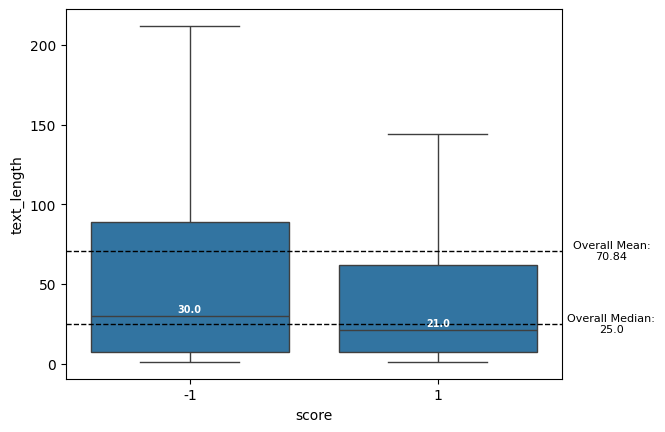

In [7]:
def generate_length_boxplot(df_stemmed: pd.DataFrame, col_text: str, col_score: str):

    from matplotlib import pyplot as plt
    import seaborn as sns

    df_stemmed['text_length'] = df_stemmed[col_text].apply(len)
    box_plot = sns.boxplot(data=df_stemmed, x=col_score, y='text_length', showfliers=False)

    medians = df_stemmed.groupby([col_score])['text_length'].median()
    vertical_offset = df_stemmed['text_length'].median() * 0.1

    for score in (-1, 1):
        box_plot.text(int(score>0), medians[score] + vertical_offset, medians[score],
                      horizontalalignment='center',size='x-small',color='w',weight='semibold')

    overall_median = df_stemmed['text_length'].median()
    box_plot.axhline(overall_median, color='black', linestyle='--', lw=1)
    plt.text(1.7, overall_median, f'Overall Median:\n{overall_median}', horizontalalignment='center', verticalalignment='center', fontsize=8)

    overall_mean = round(df_stemmed['text_length'].mean(), 2)
    box_plot.axhline(overall_mean, color='black', linestyle='--', lw=1)
    plt.text(1.7, overall_mean, f'Overall Mean:\n{overall_mean}', horizontalalignment='center', verticalalignment='center', fontsize=8)

    plt.show()

df_stemmed = read_tokenized_csv('datasets/steam_200000_stemmed.csv', 'text')
generate_length_boxplot(df_stemmed, 'text', 'score')

Negative reviews are longer on average as compared to positive reviews. The large discrepency between the mean and median indicate that the distribution of review lengths is skewed towards shorter reviews. At the same time, there are a few outliers of very long reviews that pull away from the median.

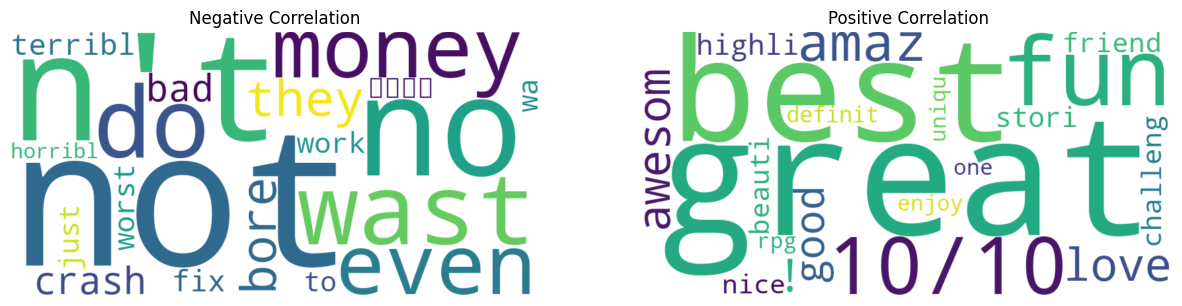

In [8]:
def generate_wordcloud(tfidf_df: pd.DataFrame, col_score: str, N: int):

    from matplotlib import pyplot as plt
    from wordcloud import WordCloud

    correlation = tfidf_df.drop(columns=[col_score]).corrwith(tfidf_df[col_score])

    neg_corr = -correlation[correlation < 0]
    pos_corr = correlation[correlation > 0]

    high_neg = neg_corr.nlargest(N)
    high_pos = pos_corr.nlargest(N)

    negative_wordcloud_data = {token: corr for token, corr in high_neg.items()}
    positive_wordcloud_data = {token: corr for token, corr in high_pos.items()}

    negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(negative_wordcloud_data)
    positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(positive_wordcloud_data)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(negative_wordcloud, interpolation='bilinear')
    plt.title('Negative Correlation')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(positive_wordcloud, interpolation='bilinear')
    plt.title('Positive Correlation')
    plt.axis('off')

    plt.show()

tfidf_df = pd.read_csv('datasets/steam_200000_tfidf.csv')
generate_wordcloud(tfidf_df, 'score', 20)

# Split Data

We then split the data into training and testing with an 80-20 ratio.

In [9]:
from sklearn.model_selection import train_test_split

def split_data(data, column_score, test_size=0.2, random_state=42):
    """
    Split data into training and testing sets

    Args:
    data: pandas dataframe
    column_score: string
    test_size: float
    """
    X = data.drop(columns=[column_score])
    y = data[column_score]
    y = y.replace(-1, 0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    return X_train, X_test, y_train, y_test

tfidf_df = pd.read_csv('datasets/steam_200000_tfidf.csv')
X_train_tf, X_test_tf, y_train_tf, y_test_tf = split_data(tfidf_df, 'score')
w2v_df = pd.read_csv('datasets/steam_200000_w2v.csv')
X_train_wv, X_test_wv, y_train_wv, y_test_wv = split_data(w2v_df, 'score')

# Model Training

We explore both non-deep learning models, as well as deep-learning models. We start each section with a baseline model, ie a basic model without tuning as comparison to our other models. For both methods, we explore both TF-IDF and word2vec schemes.

To determine and compare model performance of our binary classification task of sentiment analysis, here are the metrics we used:
  * Non-Deep Learning Models: F1 Score
    * Where The formula is given as:
    \begin{align}
          F1 = 2×\frac{precision×recall}{precision+recall}
    \end{align}

    * Precision is the measure of accurate predictions
    * Recall is the measure of relevant predctions
    * F1 provides the harmonic mean of both the Precision and Recall metrics
    * It is useful in Sentiment Analysis because we would like to consider the best possible results (ie. Most True Positives and True Negatives)
    * It also considers False Positives and Negative, thus F1 score is more robust to noise in data. Since our models are trained on pop-culture data, we are more likely to face such noise. Thus the F1 score is a good metric.

  * Deep-Learning Models: AUC-PRC
    * Area under the Precision - Recall curve
    * Showcases Overall Performance over all possible classification thresholds
    * Useful for binary classification tasks (as we are doing)
    * Similar as above

We also kept track of the accuracy of the models as it was more tangible, but our main focus is the F1 Score and AUC-PRC.

## Non-deep Learning

Helper functions for fitting

In [10]:
def fit_tfidf(model):
    """
    Generate a sample non-deep learning model
    """
    model.fit(X_train_tf, y_train_tf)
    return model

def fit_w2v(model):
    """
    Generate a sample non-deep learning model
    """
    model.fit(X_train_wv, y_train_wv)
    return model

Helper function for model evaluation

In [11]:
def evaluate_model_tfidf(model):
    """
    Evaluate model
    """
    from sklearn.metrics import f1_score, classification_report, accuracy_score
    y_pred = model.predict(X_test_tf)
    print(classification_report(y_test_tf, y_pred))
    return f1_score(y_test_tf, y_pred), accuracy_score(y_test_tf, y_pred)

def evaluate_model_w2v(model):
    """
    Evaluate model
    """
    from sklearn.metrics import f1_score, classification_report, accuracy_score
    y_pred = model.predict(X_test_wv)
    print(classification_report(y_test_wv, y_pred))
    return f1_score(y_test_wv, y_pred), accuracy_score(y_test_wv, y_pred)

Helper functions for tuning

In [12]:
def tuner_tfidf(model, param_distributions, n_splits=5, n_iter=5, verbose=0):
    from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    random_search = RandomizedSearchCV(model,
                                       param_distributions=param_distributions,
                                       cv=kf,
                                       n_iter=n_iter,
                                       n_jobs=-1,
                                       verbose=verbose,
                                       scoring="f1")
    random_search = fit_tfidf(random_search)
    return random_search.best_params_

def tuner_w2v(model, param_distributions, n_splits=5, n_iter=5, verbose=0):
    from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    random_search = RandomizedSearchCV(model,
                                       param_distributions=param_distributions,
                                       cv=kf,
                                       n_iter=n_iter,
                                       n_jobs=-1,
                                       verbose=verbose,
                                       scoring="f1")
    random_search = fit_w2v(random_search)
    return random_search.best_params_

### Baseline Models (Decision Tree)

We created 2 base models as benchmarks to compare our models against. These are untuned decision tree models, one for tf-idf vectors and one for the word2vec vectors.

#### tfidf

In [13]:
def dt_tfidf_model():
    from sklearn.tree import DecisionTreeClassifier
    dt_clf = DecisionTreeClassifier()
    return fit_tfidf(dt_clf)

# dt_tf = dt_tfidf_model()
# save_pkl(dt_tf, 'model/base_dt_tfidf.pkl')
dt_tf = load_pkl('model/base_dt_tfidf.pkl')
evaluate_model_tfidf(dt_tf)

              precision    recall  f1-score   support

           0       0.65      0.75      0.70     19072
           1       0.71      0.60      0.65     19507

    accuracy                           0.68     38579
   macro avg       0.68      0.68      0.68     38579
weighted avg       0.68      0.68      0.68     38579



(0.6541568355308813, 0.6770522823297649)

#### w2v

In [14]:
def dt_w2v_model():
    from sklearn.tree import DecisionTreeClassifier
    dt_clf = DecisionTreeClassifier()
    return fit_w2v(dt_clf)

# dt_wv = dt_w2v_model()
# save_pkl(dt_wv, 'model/base_dt_w2v.pkl')
dt_wv = load_pkl('model/base_dt_w2v.pkl')
evaluate_model_w2v(dt_wv)

              precision    recall  f1-score   support

           0       0.63      0.73      0.67     19072
           1       0.68      0.58      0.63     19507

    accuracy                           0.65     38579
   macro avg       0.66      0.65      0.65     38579
weighted avg       0.66      0.65      0.65     38579



(0.6289782012575132, 0.652790378185023)

### Random Forest

In our random forest models, we decided to tune two parameters:
- `max_features`: The number of features to consider when looking for the best split. Adjusting this parameter helps to control overfitting or underfitting
- `max_samples`: The proportion of samples to draw from the dataset to train each tree in the ensemble (bagging).

#### tfidf

Tuning

In [15]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform

rf = RandomForestClassifier()
param_dist = dict(max_features=uniform(), max_samples=uniform())

# best_params_rf_tfidf = tuner_tfidf(rf, param_dist, verbose=2, n_iter=10)
# best_params_rf_tfidf = {'max_features': 0.015160490479860789, 'max_samples': 0.5569060911967647}

In [16]:
def rf_tfidf_model(params):
    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=300, **params)
    return fit_tfidf(rf)

# rf_tf = rf_tfidf_model(best_params_rf_tfidf)
# save_pkl(rf_tf, 'model/rf_tfidf.pkl')
rf_tf = load_pkl('model/rf_tfidf.pkl')
evaluate_model_tfidf(rf_tf)

              precision    recall  f1-score   support

           0       0.71      0.86      0.78     19072
           1       0.83      0.66      0.74     19507

    accuracy                           0.76     38579
   macro avg       0.77      0.76      0.76     38579
weighted avg       0.77      0.76      0.76     38579



(0.7357931898417037, 0.7594546255734985)

#### w2v

In [17]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform

rf = RandomForestClassifier()
param_dist = dict(max_features=uniform(), max_samples=uniform())

# best_params_rf_w2v = tuner_w2v(rf, param_dist, verbose=2, n_iter=8)
# best_params_rf_w2v = {'max_features': 0.3029878098534021, 'max_samples': 0.7570946992026618}

In [18]:
def rf_w2v_model(params):
    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=300, **params)
    return fit_w2v(rf)

# rf_wv = rf_w2v_model(best_params_rf_w2v)
# save_pkl(rf_wv, 'model/rf_w2v.pkl')
rf_wv = load_pkl('model/rf_w2v.pkl')
evaluate_model_w2v(rf_wv)

              precision    recall  f1-score   support

           0       0.71      0.82      0.76     19072
           1       0.79      0.67      0.73     19507

    accuracy                           0.75     38579
   macro avg       0.75      0.75      0.74     38579
weighted avg       0.75      0.75      0.74     38579



(0.7285061608749827, 0.7458461857487234)

### SVC

In the support vector classifier models, we tuned the `C` hyperparameter. This controls the strength of regularization, which is inversely proportional to C.

#### tfidf

In [19]:
from sklearn.svm import LinearSVC

linear_svm = LinearSVC()

param_grid = {'C': [0.1, 1, 10]}

# best_params_svc_tfidf = tuner_tfidf(linear_svm, param_grid, verbose=1)
# best_params_svc_tfidf = {'C': 1}

In [20]:
def svc_tfidf_model(params):
    from sklearn.svm import LinearSVC
    svc = LinearSVC(**params)
    return fit_tfidf(svc)

# svc_tf = svc_tfidf_model(best_params_svc_tfidf)
# save_pkl(svc_tf, 'model/svc_tfidf.pkl')
svc_tf = load_pkl('model/svc_tfidf.pkl')
evaluate_model_tfidf(svc_tf)

              precision    recall  f1-score   support

           0       0.72      0.84      0.77     19072
           1       0.81      0.68      0.74     19507

    accuracy                           0.76     38579
   macro avg       0.77      0.76      0.76     38579
weighted avg       0.77      0.76      0.76     38579



(0.740649976329054, 0.7585992379273698)

#### word2vec

In [21]:
from sklearn.svm import LinearSVC

linear_svm = LinearSVC()

param_grid = {'C': [0.1, 1, 10]}

# best_params_svc_w2v = tuner_w2v(linear_svm, param_grid, verbose=1)
# best_params_svc_w2v = {'C': 1}

In [22]:
def svc_w2v_model(params):
    from sklearn.svm import LinearSVC
    svc = LinearSVC(**params)
    return fit_w2v(svc)

# svc_wv = svc_w2v_model(best_params_svc_w2v)
# save_pkl(svc_wv, 'model/svc_w2v.pkl')
svc_wv = load_pkl('model/svc_w2v.pkl')
evaluate_model_w2v(svc_wv)

              precision    recall  f1-score   support

           0       0.71      0.84      0.77     19072
           1       0.81      0.67      0.73     19507

    accuracy                           0.75     38579
   macro avg       0.76      0.75      0.75     38579
weighted avg       0.76      0.75      0.75     38579



(0.732055257964477, 0.7536483579149278)

### Naive Bayes

Gaussian Naive Bayes is a simple yet powerful probabilistic classifier based on Bayes' theorem and the assumption of feature independence. For this, we tuned `var_smoothing`,
which is a smoothing parameter that accounts for features with zero variance. It is a regularization parameter that adds a fraction of the largest variance of all features to the variances for calculation stability.

#### tfidf

In [23]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
param_dist = {'var_smoothing': np.logspace(0,-9, num=100)}

# best_params_gnb_tfidf = tuner_tfidf(gnb, param_dist, verbose=2, n_iter=20)
# best_params_gnb_tfidf = {'var_smoothing': 0.0015199110829529332}

In [24]:
def gnb_tfidf_model(params):
    from sklearn.naive_bayes import GaussianNB
    gnb = GaussianNB(**params)
    return fit_tfidf(gnb)

# gnb_tf = gnb_tfidf_model(best_params_gnb_tfidf)
# save_pkl(gnb_tf, 'model/gnb_tfidf.pkl')
gnb_tf = load_pkl('model/gnb_tfidf.pkl')
evaluate_model_tfidf(gnb_tf)

              precision    recall  f1-score   support

           0       0.74      0.61      0.67     19072
           1       0.68      0.79      0.73     19507

    accuracy                           0.70     38579
   macro avg       0.71      0.70      0.70     38579
weighted avg       0.71      0.70      0.70     38579



(0.7307901263729775, 0.7045802120324529)

#### word2vec

In [25]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
param_dist = {'var_smoothing': np.logspace(0,-9, num=100)}

# best_params_gnb_w2v = tuner_w2v(gnb, param_dist, verbose=2, n_iter=20)
# best_params_gnb_w2v = {'var_smoothing': 1e-06}

In [26]:
def gnb_w2v_model(params):
    from sklearn.naive_bayes import GaussianNB
    gnb = GaussianNB(**params)
    return fit_w2v(gnb)

# gnb_wv = gnb_w2v_model(best_params_gnb_w2v)
# save_pkl(gnb_wv, 'model/gnb_w2v.pkl')
gnb_wv = load_pkl('model/gnb_w2v.pkl')
evaluate_model_w2v(gnb_wv)

              precision    recall  f1-score   support

           0       0.61      0.77      0.68     19072
           1       0.70      0.51      0.59     19507

    accuracy                           0.64     38579
   macro avg       0.65      0.64      0.63     38579
weighted avg       0.65      0.64      0.63     38579



(0.5886676149834045, 0.6402187718707069)

### AdaBoost

Short for Adaptive Boosting, AdaBoost is another ensemble learning method. The key idea is to sequentially train a series of weak learners (decision trees) each focusing on the instances that previous learners have misclassified. During training, AdaBoost assigns higher weights to the misclassified instances, thereby forcing subsequent weak learners to focus more on these difficult-to-classify instances. We tuned the following parameters:

- `n_estimators`: The number of weak learners (decision trees) to train iteratively. A higher number of estimators can lead to better performance, but it also increases computational cost.

- `learning_rate`: This parameter shrinks the contribution of each weak learner. Lower values require more estimators to achieve the same level of performance, but they can also lead to better generalization.

#### tfidf

In [27]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(algorithm="SAMME")
param_dist = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.5, 1.0]
}

# best_params_abc_tfidf = tuner_tfidf(abc, param_dist, verbose=1,n_iter=10)
# best_params_abc_tfidf = {'n_estimators': 150, 'learning_rate': 1.0}

In [28]:
def abc_tfidf_model(params):
    from sklearn.ensemble import AdaBoostClassifier
    abc = AdaBoostClassifier(algorithm="SAMME", **params)
    return fit_tfidf(abc)

# abc_tf = abc_tfidf_model(best_params_abc_tfidf)
# save_pkl(abc_tf, 'model/abc_tfidf.pkl')
abc_tf = load_pkl('model/abc_tfidf.pkl')
evaluate_model_tfidf(abc_tf)

              precision    recall  f1-score   support

           0       0.76      0.59      0.66     19072
           1       0.67      0.82      0.74     19507

    accuracy                           0.71     38579
   macro avg       0.72      0.70      0.70     38579
weighted avg       0.72      0.71      0.70     38579



(0.7376780478795854, 0.7054615205163431)

#### word2vec

In [29]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(algorithm="SAMME")
param_dist = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.5, 1.0]
}

# best_params_abc_w2v = tuner_w2v(abc, param_dist, verbose=2, n_iter=10)
# best_params_abc_w2v = {'n_estimators': 150, 'learning_rate': 1.0}

In [30]:
def abc_w2v_model(params):
    from sklearn.ensemble import AdaBoostClassifier
    abc = AdaBoostClassifier(algorithm="SAMME", **params)
    return fit_w2v(abc)

# abc_wv = abc_w2v_model(best_params_abc_w2v)
# save_pkl(abc_wv, 'model/abc_w2v.pkl')
abc_wv = load_pkl('model/abc_w2v.pkl')
evaluate_model_w2v(abc_wv)

              precision    recall  f1-score   support

           0       0.70      0.81      0.75     19072
           1       0.78      0.65      0.71     19507

    accuracy                           0.73     38579
   macro avg       0.74      0.73      0.73     38579
weighted avg       0.74      0.73      0.73     38579



(0.7109054931579387, 0.7311231499002048)

### XGBoost

XGBoost (Extreme Gradient Boosting) is an implementation of gradient boosting machines, which sequentially combines weak learners (decision trees) to create a strong learner. Compared to random forests, it can capture more complex relationships between features and target variables due to its sequential nature and gradient-based optimization. Here are the parameters we tuned for the XGBoost Classifier:

- `learning_rate`: The step size at each iteration. Lower values can make the model more robust but require more boosting rounds.
- `gamma`: Minimum loss reduction required to make a further partition on a leaf node of the tree. It acts as regularization.
- `subsample`: Subsample ratio to draw from the training set. Lower values make the algorithm more conservative and prevent overfitting.
- `colsample_bytree`: Subsample ratio of columns when constructing each tree. Similar to subsample but for features.
- `lambda` and `alpha`: L1 and L2 regularization terms. They add penalties on the complexity of the model to prevent overfitting.

#### tfidf

In [31]:
from xgboost import XGBClassifier
from scipy.stats import uniform, loguniform

xgb_clf = XGBClassifier(objective='binary:logistic')
param_dist = {'learning_rate': uniform(0.01, 0.3),
              'gamma': uniform(0.1, 5),
              'subsample': uniform(0.5, 0.5),
              'colsample_bytree': uniform(0.5, 0.5),
              'lambda': loguniform(1e-4, 1.0),
              'alpha': loguniform(1e-4, 1.0)
             }

# best_params_xgb_tfidf = tuner_tfidf(xgb_clf, param_dist, verbose=2, n_iter=20)
# best_params_xgb_tfidf = {'alpha': 0.004135431006550945,
#  'colsample_bytree': 0.7578634174054832,
#  'gamma': 3.4513857699952575,
#  'lambda': 0.001426118940281082,
#  'learning_rate': 0.2883552972314986,
#  'subsample': 0.6155320812152348}

In [32]:
def xgb_tfidf_model(params):
    from xgboost import XGBClassifier
    xgb = XGBClassifier(objective='binary:logistic', **params)
    return fit_tfidf(xgb)

# xgb_tf = xgb_tfidf_model(best_params_xgb_tfidf)
# save_pkl(xgb_tf, 'model/xgb_tfidf.pkl')
xgb_tf = load_pkl('model/xgb_tfidf.pkl')
evaluate_model_tfidf(xgb_tf)

              precision    recall  f1-score   support

           0       0.72      0.83      0.77     19072
           1       0.80      0.69      0.74     19507

    accuracy                           0.76     38579
   macro avg       0.76      0.76      0.76     38579
weighted avg       0.76      0.76      0.76     38579



(0.7431185077012096, 0.7583400295497551)

#### word2vec

In [33]:
from xgboost import XGBClassifier
from scipy.stats import uniform, loguniform

xgb_clf = XGBClassifier(objective='binary:logistic')
param_dist = {'learning_rate': uniform(0.01, 0.3),
              'gamma': uniform(0.1, 5),
              'subsample': uniform(0.5, 0.5),
              'colsample_bytree': uniform(0.5, 0.5),
              'lambda': loguniform(1e-4, 1.0),
              'alpha': loguniform(1e-4, 1.0)
             }

# best_params_xgb_w2v = tuner_w2v(xgb_clf, param_dist, verbose=2, n_iter=20)
# best_params_xgb_w2v = {'alpha': 0.00038755162623603414,
#  'colsample_bytree': 0.5385316554923127,
#  'gamma': 4.601373651684341,
#  'lambda': 0.0003445604241578642,
#  'learning_rate': 0.2260069812433313,
#  'subsample': 0.9390815931412955}

In [34]:
def xgb_w2v_model(params):
    from xgboost import XGBClassifier
    xgb = XGBClassifier(objective='binary:logistic', **params)
    return fit_w2v(xgb)

# xgb_wv = xgb_w2v_model(best_params_xgb_w2v)
# save_pkl(xgb_wv, 'model/xgb_w2v.pkl')
xgb_wv = load_pkl('model/xgb_w2v.pkl')
evaluate_model_w2v(xgb_wv)

              precision    recall  f1-score   support

           0       0.72      0.85      0.78     19072
           1       0.82      0.68      0.74     19507

    accuracy                           0.76     38579
   macro avg       0.77      0.76      0.76     38579
weighted avg       0.77      0.76      0.76     38579



(0.7426028049156006, 0.761657896783224)

## Deep Learning

### Process Data to Numpy Arrays

In [35]:
def convert_to_np(X_train, X_test, y_train, y_test):
    """
    Convert data to numpy arrays

    Args:
    X_train: pandas series
    X_test: pandas series
    y_train: pandas series
    y_test: pandas series
    """
    X_train_np = X_train.to_numpy()
    X_test_np = X_test.to_numpy()
    y_train_np = y_train.to_numpy()
    y_test_np = y_test.to_numpy()

    return X_train_np, X_test_np, y_train_np, y_test_np

X_train_tf_np, X_test_tf_np, y_train_tf_np, y_test_tf_np = convert_to_np(X_train_tf, X_test_tf, y_train_tf, y_test_tf)
X_train_wv_np, X_test_wv_np, y_train_wv_np, y_test_wv_np = convert_to_np(X_train_wv, X_test_wv, y_train_wv, y_test_wv)

### Helper functions

In [36]:
def save_keras(model, file_path):
    """
    Save model to disk, end with .keras
    """
    model.save(file_path)

def load_keras(file_path):
    """
    Load model from disk
    """
    import keras
    return keras.saving.load_model(file_path)

def metrics(y_test_np, y_pred):
    from matplotlib import pyplot as plt
    from sklearn.metrics import precision_recall_curve, average_precision_score, accuracy_score

    f1_score = lambda precision, recall: 2 / (1/precision + 1/recall)
    precision, recall, thresholds = precision_recall_curve(y_test_np, y_pred)
    max_f1 = 0
    best_threshold = 0
    best_recall = 0
    best_precision = 0
    for i in range(len(thresholds)):
        if f1_score(precision[i], recall[i]) > max_f1:
            max_f1 = f1_score(precision[i], recall[i])
            best_recall = recall[i]
            best_precision = precision[i]
            best_threshold = thresholds[i]

    # Plot Precision-Recall curve
    plt.figure()
    plt.plot(recall, precision, label='PRC curve')
    plt.plot(best_recall, best_precision, marker = "x", color = "red", ms = 12, label = f"Best Threshold: {best_threshold}\nMax F1 Score: {max_f1}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

    return average_precision_score(y_test_np, y_pred), accuracy_score(y_test_np, y_pred > best_threshold), best_threshold, max_f1

def evaluate_deep_learning_model(model, X_test_np, y_test_np):
    """
    Evaluate deep learning model
    """
    y_pred = model.predict(X_test_np).ravel()

    return metrics(y_test_np, y_pred)



### Baseline Model

For deep learning models, our baseline models use a single hidden layer of 32 neurons. Surprisingly, these simple models perform quite well, already surpassing the best non-deep learning models in terms of f1 score. We aim to improve the performance by hyperparameter tuning and exploring different model architectures.

In [37]:
def base_model(X_train_np, y_train_np):
    """
    Generate a sample deep learning model
    """
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.metrics import AUC

    model = Sequential()
    model.add(Dense(32, input_shape=(X_train_np.shape[1],), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=[AUC(curve="PR")])
    model.fit(X_train_np, y_train_np, epochs = 10, batch_size = 32, verbose = 2)
    return model

1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 390us/step


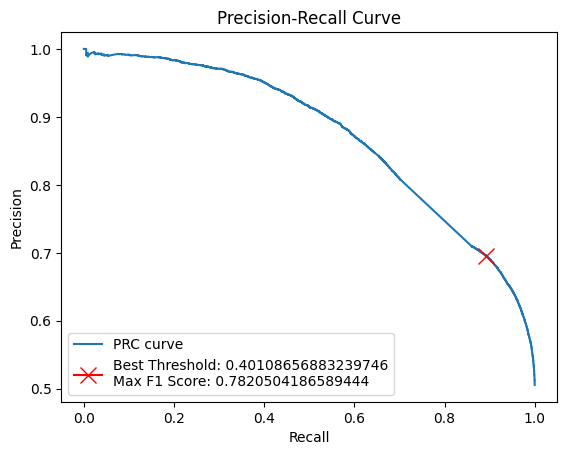

(0.8646502976633457, 0.7483086653360637, 0.40108657, 0.7820504186589444)

In [38]:
# base_tfidf = base_model(X_train_tf_np, y_train_tf_np)
# save_keras(base_tfidf, 'model/base_tfidf.keras')
base_tfidf = load_keras('model/base_tfidf.keras')
evaluate_deep_learning_model(base_tfidf, X_test_tf_np, y_test_tf_np)

 254/1206 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step

1206/1206 ━━━━━━━━━━━━━━━━━━━━ 0s 364us/step


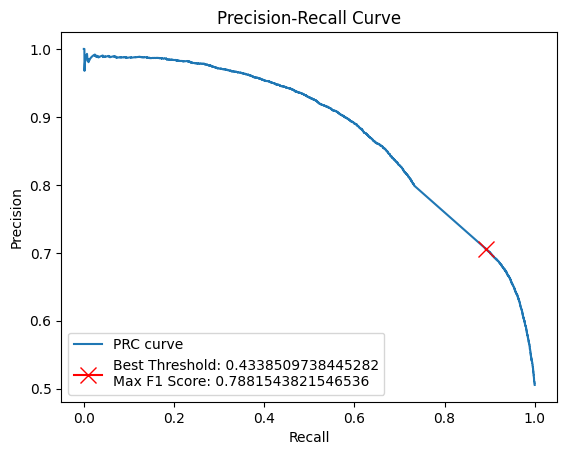

(0.8721745761275652, 0.757251354363773, 0.43385097, 0.7881543821546536)

In [39]:
# base_wv = base_model(X_train_wv_np, y_train_wv_np)
# save_keras(base_wv, 'model/base_wv.keras')
base_wv = load_keras('model/base_wv.keras')
evaluate_deep_learning_model(base_wv, X_test_wv_np, y_test_wv_np)

### Model 1

First, this is a sequential model with dense layers. The parameters are chosen in a way that there is sufficient complexity for capturing patterns in data (64 neurons) and not overly computationally expensive (32 neurons). 50 epochs is chosen such that there is a balance between training the model sufficiently over the data and avoiding overfitting. 32 batch size is chose such that there is good convergence of the gradient without being too noisy.

The model is then tuned with double the dense neurons in both layers.

In [40]:
def deep_model_1(X_train_np, y_train_np):
    """
    Generate a sample deep learning model
    """
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.optimizers import Adam
    from keras.losses import BinaryCrossentropy
    from keras.metrics import BinaryAccuracy

    model = Sequential()
    model.add(Dense(64, input_dim=X_train_np.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss=BinaryCrossentropy(), optimizer=Adam(), metrics=[BinaryAccuracy()])
    model.fit(X_train_np, y_train_np, epochs = 50, batch_size = 32)
    return model

In [41]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy

def tuned_deep_model_1(X_train_np, y_train_np, input_dim, hyperparameters):
    """
    Generate and tune a deep learning model using precomputed word embeddings.
    """

    model = Sequential()

    model.add(Dense(hyperparameters['first_layer_units'], input_dim=input_dim, activation='relu'))

    for units in hyperparameters['additional_layers_units']:
        model.add(Dense(units, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=hyperparameters['learning_rate'])
    model.compile(optimizer=optimizer, loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])
    model.fit(X_train_np, y_train_np, epochs=hyperparameters['epochs'], batch_size=hyperparameters['batch_size'], verbose=1)

    return model

hyperparameters = {
    'first_layer_units': 128,
    'additional_layers_units': [64],
    'learning_rate': 0.001,
    'epochs': 50,
    'batch_size': 32
}

# model_tfidf = tuned_deep_model_1(X_train_tf_np, y_train_tf_np, input_dim=X_train_tf_np.shape[1], hyperparameters=hyperparameters)

# model_w2v = tuned_deep_model_1(X_train_wv_np, y_train_wv_np, input_dim=100, hyperparameters=hyperparameters)


 718/1206 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step

1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 423us/step


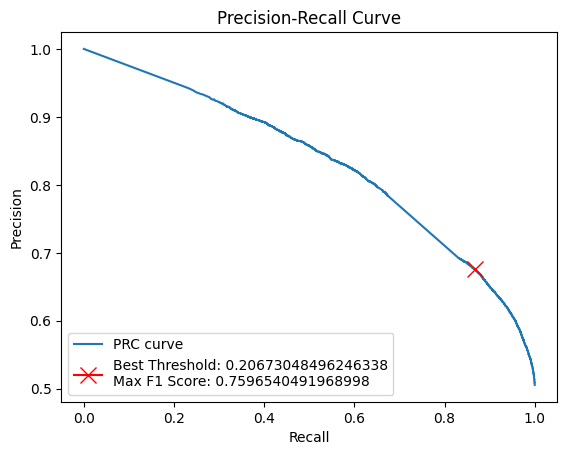

(0.8191819509718135, 0.7226470359522019, 0.20673048, 0.7596540491968998)

In [42]:
# dense_tf = deep_model_1(X_train_tf_np, y_train_tf_np)
# # save_keras(dense_tf, 'model/dense_tf.keras')
deep_model_tfidf = load_keras('model/dense_tf.keras')
evaluate_deep_learning_model(deep_model_tfidf, X_test_tf_np, y_test_tf_np)

   1/1206 ━━━━━━━━━━━━━━━━━━━━ 43s 36ms/step

1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 462us/step


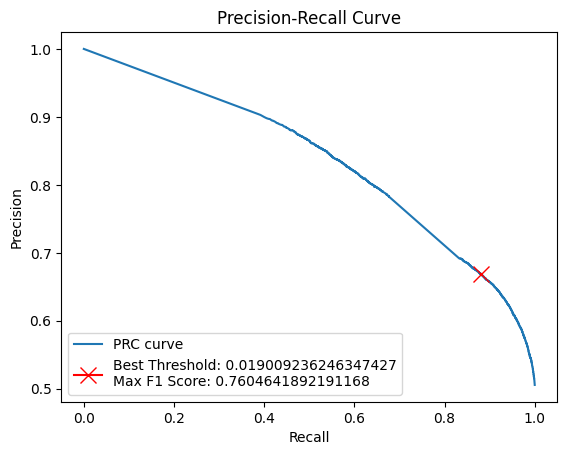

(0.8101096846276719, 0.7196142979341092, 0.019009236, 0.7604641892191168)

In [43]:
# dense_tf_tuned = model_tfidf
# save_keras(dense_tf_tuned, 'model/dense_tf_tuned.keras')
dense_tf_tuned = load_keras('model/dense_tf_tuned.keras')
evaluate_deep_learning_model(dense_tf_tuned, X_test_tf_np, y_test_tf_np)

 118/1206 ━━━━━━━━━━━━━━━━━━━━ 0s 428us/step

1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 523us/step


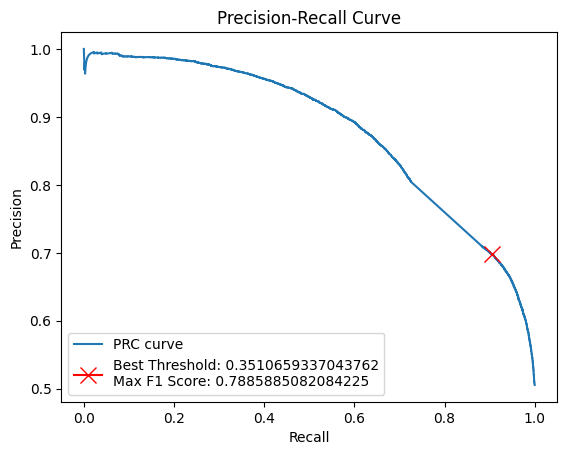

(0.8732817315200954, 0.7542963788589647, 0.35106593, 0.7885885082084225)

In [44]:
# dense_w2v = deep_model_1(X_train_wv_np, y_train_wv_np)
# save_keras(dense_w2v, 'model/dense_w2v.keras')
dense_w2v = load_keras('model/dense_w2v.keras')
evaluate_deep_learning_model(dense_w2v, X_test_wv_np, y_test_wv_np)

 172/1206 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step

1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 485us/step


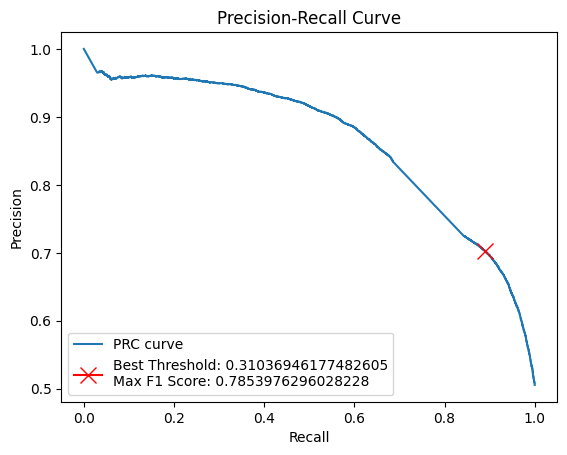

(0.8558709472212609, 0.75403717048135, 0.31036946, 0.7853976296028228)

In [45]:
# dense_w2v_tuned = model_w2v
# save_keras(dense_w2v_tuned, 'model/dense_w2v_tuned.keras')
dense_w2v_tuned = load_keras('model/dense_w2v_tuned.keras')
evaluate_deep_learning_model(dense_w2v_tuned, X_test_wv_np, y_test_wv_np)

### Model 2: Dense + dropout

This model is pretty similar to the previous model except that a drop out layer is added with dropout rate equal to 0.5, which is quite an aggresive approach to prevent overfitting.

In the tuned model, we doubled the neurons in dense layer as before and we took a less aggresive approach by setting dropout rate to be 0.2.

In [46]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy

def deep_model_2(X_train_np, y_train_np):
    """
    Generate a sample deep learning model with dropout layers
    """
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_np.shape[1], activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss=BinaryCrossentropy(), optimizer=Adam(), metrics=[BinaryAccuracy()])
    model.fit(X_train_np, y_train_np, epochs=50, batch_size=32, verbose=0)
    return model

In [47]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy

def tuned_deep_model2(X_train_np, y_train_np, input_dim, hyperparameters):
    """
    Generate and tune a deep learning model with dropout layers.
    """

    model = Sequential()
    model.add(Dense(hyperparameters['first_layer_units'], input_dim=input_dim, activation='relu'))
    model.add(Dropout(hyperparameters['dropout_rate']))

    for units in hyperparameters['additional_layers_units']:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(hyperparameters['dropout_rate']))

    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=hyperparameters['learning_rate'])
    model.compile(optimizer=optimizer, loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])
    model.fit(X_train_np, y_train_np, epochs=hyperparameters['epochs'], batch_size=hyperparameters['batch_size'], verbose=1)

    return model

hyperparameters = {
    'first_layer_units': 128,
    'additional_layers_units': [64],
    'dropout_rate': 0.2,
    'learning_rate': 0.001,
    'epochs': 50,
    'batch_size': 32
}


# model_tfidf_with_dropout = tuned_deep_model2(X_train_tf_np, y_train_tf_np, X_train_tf_np.shape[1], hyperparameters)
# model_w2v_with_dropout = tuned_deep_model2(X_train_wv_np, y_train_wv_np, 100, hyperparameters)

  45/1206 ━━━━━━━━━━━━━━━━━━━━ 29s 25ms/step

1206/1206 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step


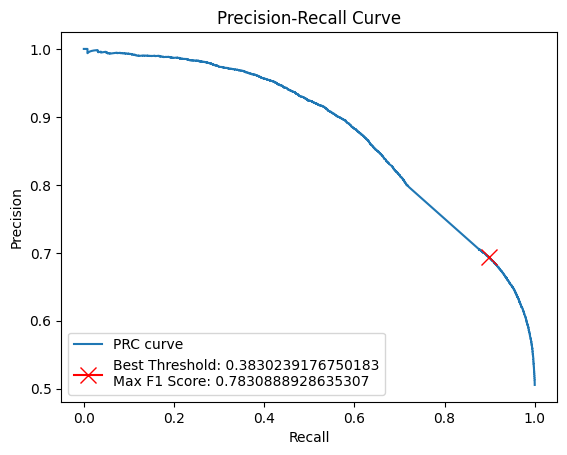

(0.8701040296608085, 0.748490111200394, 0.38302392, 0.7830888928635307)

In [48]:
# densedropout_tf = deep_model_2(X_train_tf_np, y_train_tf_np)
# save_keras(densedropout_tf, 'model/densedropout_tf.keras')
densedropout_tf = load_keras('model/densedropout_tf.keras')
evaluate_deep_learning_model(densedropout_tf, X_test_tf_np, y_test_tf_np)

# 0.8717235586754026

 108/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 945us/step

1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 611us/step


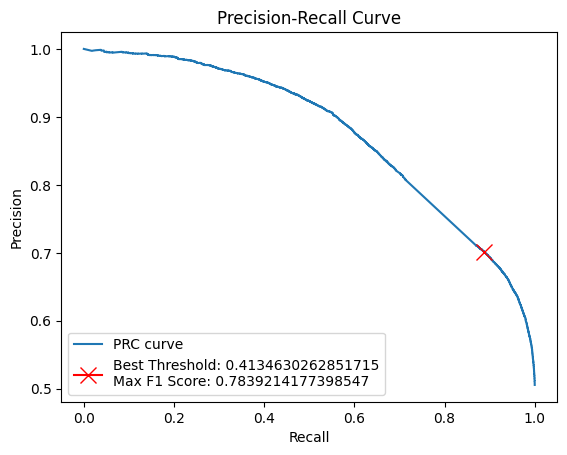

(0.8692557617628278, 0.7525078410534228, 0.41346303, 0.7839214177398547)

In [49]:
# densedropout_tf_tuned = model_tfidf_with_dropout
# save_keras(densedropout_tf_tuned, 'model/densedropout_tf_tuned.keras')
densedropout_tf_tuned = load_keras('model/densedropout_tf_tuned.keras')
evaluate_deep_learning_model(densedropout_tf_tuned, X_test_tf_np, y_test_tf_np)

# 0.8692561878558211

  88/1206 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step

1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 781us/step


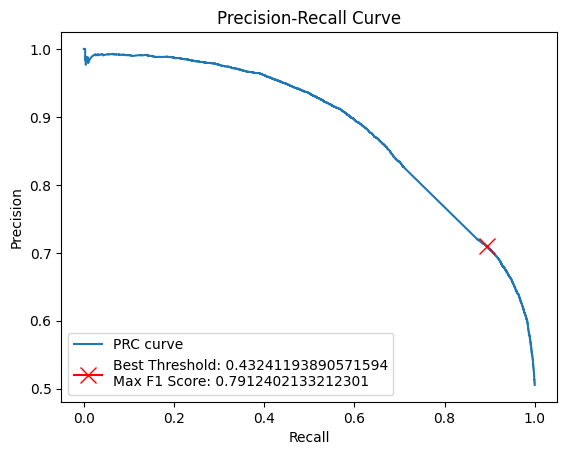

(0.8759331717765729, 0.7615282925944167, 0.43241194, 0.7912402133212301)

In [50]:
# densedropout_w2v = deep_model_2(X_train_wv_np, y_train_wv_np)
# save_keras(densedropout_w2v, 'model/densedropout_w2v.keras')
densedropout_w2v = load_keras('model/densedropout_w2v.keras')
evaluate_deep_learning_model(densedropout_w2v, X_test_wv_np, y_test_wv_np)

# 0.875933222253425

 128/1206 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step

1206/1206 ━━━━━━━━━━━━━━━━━━━━ 1s 571us/step


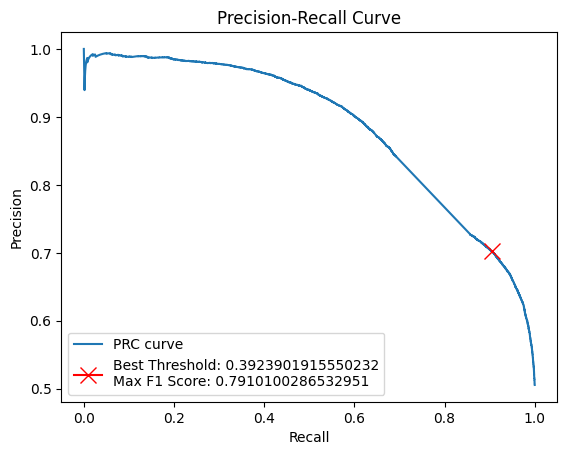

(0.87671105464053, 0.7579771378210943, 0.3923902, 0.7910100286532951)

In [51]:
# densedropout_w2v_tuned = model_w2v_with_dropout
# save_keras(densedropout_w2v_tuned, 'model/densedropout_w2v_tuned.keras')
densedropout_w2v_tuned = load_keras('model/densedropout_w2v_tuned.keras')
evaluate_deep_learning_model(densedropout_w2v_tuned, X_test_wv_np, y_test_wv_np)

# 0.8767137007484711

### Model 3: CNN

We choose the first convolution layer with 128 filters and 5 kernel size to extract high-level features from the text, then the second convolution layer has a smaller number of filters to capture higher-level semantics of the input text. Pool size and dropout rate are standard practice so we chose them.

To tune this model, we reduced the number of filters and kernel size in the first layer and added 2 additional layers instead of one. We added an additional layer of dense layer and increased more neurons to capture more features. We increaed the epoch size because the model seems to have not converged, we reduce the batch size to balance the computation time.

In [52]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def cnn_model(X_train_np, y_train_np):
    """
    Generate a sample 1D Convolutional Neural Network model for text data.
    """
    model = Sequential()
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(X_train_np.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_np, y_train_np, epochs=10, batch_size=64, verbose=1)

    return model

In [53]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import BinaryAccuracy

def tuned_cnn_model(X_train_np, y_train_np, input_dim, hyperparameters):
    """
    Generate and tune a 1D CNN model using precomputed word embeddings.
    """

    model = Sequential()

    model.add(Conv1D(filters=hyperparameters['first_layer_filters'],
                     kernel_size=hyperparameters['first_layer_kernel_size'],
                     activation='relu',
                     input_shape=(input_dim, 1)))
    model.add(MaxPooling1D(pool_size=hyperparameters['first_layer_pooling_size']))
    model.add(Dropout(hyperparameters['first_layer_dropout']))

    for layer in hyperparameters['additional_layers']:
        model.add(Conv1D(filters=layer['filters'],
                         kernel_size=layer['kernel_size'],
                         activation='relu'))
        model.add(MaxPooling1D(pool_size=layer['pooling_size']))
        model.add(Dropout(layer['dropout']))

    model.add(Flatten())

    for units in hyperparameters['dense_layers_units']:
        model.add(Dense(units, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=hyperparameters['learning_rate'])
    model.compile(optimizer=optimizer, loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])

    model.fit(X_train_np, y_train_np, epochs=hyperparameters['epochs'], batch_size=hyperparameters['batch_size'], verbose=1)

    return model

hyperparameters_cnn = {
    'first_layer_filters': 64,
    'first_layer_kernel_size': 3,
    'first_layer_pooling_size': 2,
    'first_layer_dropout': 0.2,
    'additional_layers': [
        {'filters': 128, 'kernel_size': 5, 'pooling_size': 2, 'dropout': 0.3},
        {'filters': 128, 'kernel_size': 5, 'pooling_size': 2, 'dropout': 0.4}
    ],
    'dense_layers_units': [128, 64],
    'learning_rate': 0.001,
    'epochs': 30,
    'batch_size': 50
}


# model_cnn_tfidf = tuned_cnn_model(X_train_tf_np, y_train_tf_np, X_train_tf_np.shape[1], hyperparameters_cnn)
# model_cnn_w2v = tuned_cnn_model(X_train_wv_np, y_train_wv_np, 100, hyperparameters_cnn)


  62/1206 ━━━━━━━━━━━━━━━━━━━━ 28s 25ms/step

1206/1206 ━━━━━━━━━━━━━━━━━━━━ 32s 27ms/step


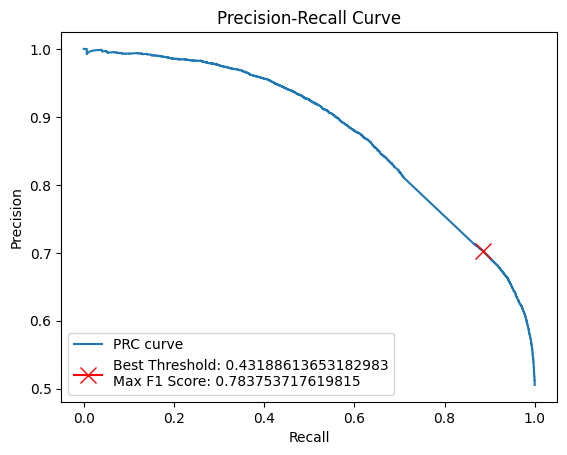

(0.8704512473778291, 0.7530780994841754, 0.43188614, 0.783753717619815)

In [54]:
# cnn_tf = cnn_model(X_train_tf_np, y_train_tf_np, )
# save_keras(cnn_tf, 'model/cnn_tf.keras')
cnn_tf = load_keras('model/cnn_tf.keras')
evaluate_deep_learning_model(cnn_tf, X_test_tf_np, y_test_tf_np)

# 0.8701040283258409

I0000 00:00:1714207370.063235 4020194 service.cc:145] XLA service 0x3b4e29ff0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714207370.063528 4020194 service.cc:153]   StreamExecutor device (0): Host, Default Version
2024-04-27 16:42:50.102652: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


  14/1206 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step 

I0000 00:00:1714207370.359065 4020194 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1206/1206 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step


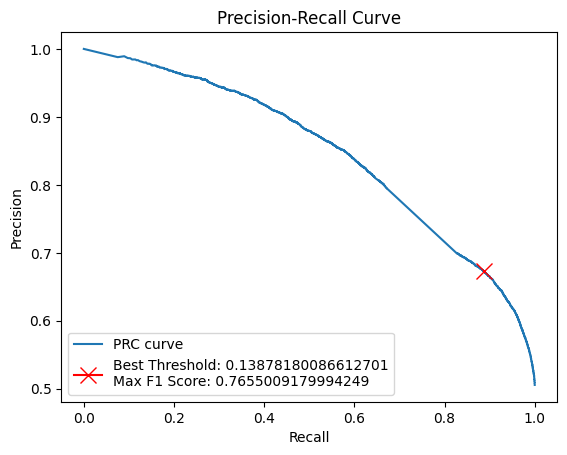

(0.8395258233447767, 0.7251872780528267, 0.1387818, 0.7655009179994249)

In [55]:
# cnn_tf_tuned = model_cnn_tfidf
# save_keras(cnn_tf_tuned, 'model/cnn_tf_tuned.keras')
cnn_tf_tuned = load_keras('model/cnn_tf_tuned.keras')
evaluate_deep_learning_model(cnn_tf_tuned, X_test_tf_np, y_test_tf_np)

# 0.8395257882977342

1206/1206 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step


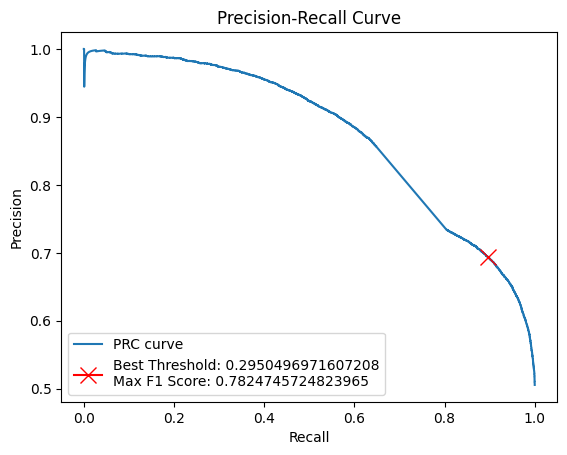

(0.8664931300612901, 0.7477384069053111, 0.2950497, 0.7824745724823965)

In [56]:
# cnn_w2v = cnn_model(X_train_wv_np, y_train_wv_np)
# save_keras(cnn_w2v, 'model/cnn_w2v.keras')
cnn_w2v = load_keras('model/cnn_w2v.keras')
evaluate_deep_learning_model(cnn_w2v, X_test_wv_np, y_test_wv_np)

# 0.8664931240415115

1206/1206 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step


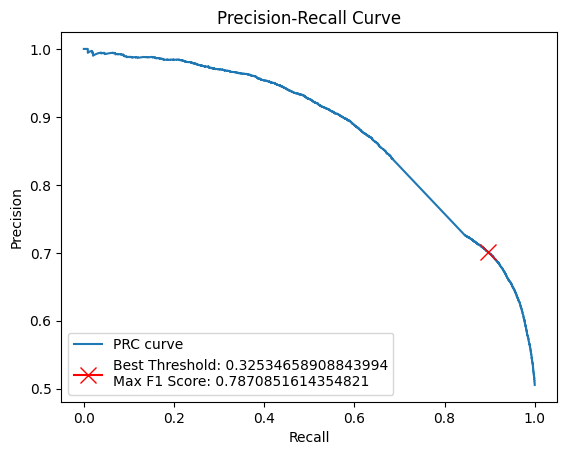

(0.8700029143918295, 0.7546851914253868, 0.3253466, 0.7870851614354821)

In [57]:
# cnn_w2v_tuned = model_cnn_w2v
# save_keras(cnn_w2v_tuned, 'model/cnn_w2v_tuned.keras')
cnn_w2v_tuned = load_keras('model/cnn_w2v_tuned.keras')
evaluate_deep_learning_model(cnn_w2v_tuned, X_test_wv_np, y_test_wv_np)
# 0.87000294075891

### Model 4: Bidirectional

For bidirectional, we need to shape our data from 2D to 3D. We choose 100 because that is just a bit more than the average length of our data. The other parameters are chosen in an attempt to balance the model complexity and overfitting.

In [58]:
from keras.models import Sequential
from keras.layers import Bidirectional, SimpleRNN, Dense, Dropout

def bidirectional_rnn_model(X_train_np, y_train_np):
    """
    Generate a sample Bidirectional Recurrent Neural Network model for text data.
    """
    X_train_np = X_train_np.reshape((X_train_np.shape[0], 5, 100))
    model = Sequential()
    model.add(Bidirectional(SimpleRNN(64, return_sequences=True), input_shape=(X_train_np.shape[1], X_train_np.shape[2])))
    model.add(Dropout(0.2))
    model.add(Bidirectional(SimpleRNN(64)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_np, y_train_np, epochs=10, batch_size=64, verbose=1)
    return model

In [59]:
# deep_model_tfidf3 = bidirectional_rnn_model(X_train_tf_np, y_train_tf_np)
# X_test_tf_reshaped = X_test_tf_np.reshape(X_test_tf_np.shape[0], 5, 100)
# evaluate_deep_learning_model(deep_model_tfidf3, X_test_tf_reshaped, y_test_tf_np)

# 0.8646155943606842

In [60]:
from keras.models import Sequential
from keras.layers import Bidirectional, SimpleRNN, Dense, Dropout

def bidirectional_rnn_model1(X_train_np, y_train_np):
    """
    Generate a sample Bidirectional Recurrent Neural Network model for text data.
    """
    X_train_np = X_train_np.reshape((X_train_np.shape[0], 1, 100))
    model = Sequential()
    model.add(Bidirectional(SimpleRNN(64, return_sequences=True), input_shape=(X_train_np.shape[1], X_train_np.shape[2])))
    model.add(Dropout(0.2))
    model.add(Bidirectional(SimpleRNN(64)))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_np, y_train_np, epochs=10, batch_size=64, verbose=1)
    return model

In [61]:
# deep_model_wv3 = bidirectional_rnn_model1(X_train_wv_np, y_train_wv_np)
# X_test_wv_reshaped = X_test_wv_np.reshape(X_test_wv_np.shape[0], 1, 100)
# evaluate_deep_learning_model(deep_model_wv3, X_test_wv_reshaped, y_test_wv_np)

# 0.8749262160735559

### Model 5: LSTM with Attention Mechanism

Long Short-Term Memory (LSTM) is a type of RNN that addresses the vanishing gradient problem in traditional RNNs. This enables our model to capture long-term dependencies in the data, helping it better understand the context of words.

The attention mechanism enhances our model by training it to focus on specific parts of the sequence, rather than processing the entire sequence uniformly. This helps the model identify key words or phrases that contribute most to the sentiment expressed in the text.

In this model, we also decided to try without pre-trained word embeddings, getting the model to learn the embeddings during the training. For this, we had to truncate or pad our reviews to be of fixed lengths. Given that the average review length is 70, we chose 70 as the sequence length.

In [62]:
from tensorflow.keras.preprocessing.text import Tokenizer

def get_sequences(df_stemmed: pd.DataFrame,
                  col_text: str,
                  col_score: str,
                  text_max_len: int) -> tuple[Tokenizer, pd.DataFrame]:

    from keras.preprocessing.sequence import pad_sequences

    text = df_stemmed[col_text].apply(' '.join).values
    score = df_stemmed[col_score].values

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)

    sequences = pad_sequences(sequences, maxlen=text_max_len)

    df_sequences = pd.DataFrame(sequences)

    df_sequences[col_score] = score

    return tokenizer, df_sequences

# df_stemmed = read_tokenized_csv('datasets/steam_200000_stemmed.csv', 'text')
# tokenizer, df_sequences = get_sequences(df_stemmed, 'text', 'score', 70)
# save_pkl(tokenizer, 'datasets/tokenizer.pkl')
# df_to_csv(df_sequences, 'datasets/steam_200000_sequences.csv')

In [63]:
tokenizer = load_pkl('datasets/tokenizer.pkl')
df_sequences = pd.read_csv('datasets/steam_200000_sequences.csv')

In [64]:
X_train, X_test, y_train, y_test = split_data(df_sequences, 'score')
X_train, X_test, y_train, y_test = convert_to_np(X_train, X_test, y_train, y_test)

In [65]:
def generate_attention_model(X_train, X_test, y_train, y_test,
                             save_path, tokenizer,
                             learning_rate=0.001, embedding_dim=100,
                             units=100, batch_size=64, epochs=100, patience=3):

    from keras.models import Model
    from keras.layers import Embedding, LSTM, Input, Attention, Concatenate, Dense
    from keras.metrics import AUC
    from keras.callbacks import EarlyStopping, ModelCheckpoint
    from keras.optimizers import Adam

    vocab_size = len(tokenizer.word_index) + 1

    input_layer = Input(shape=(X_train.shape[1],))
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)

    lstm_layer = LSTM(units, return_sequences=True)(embedding_layer)
    attention = Attention()([lstm_layer, lstm_layer])

    merged = Concatenate(axis=-1)([lstm_layer, attention])
    merged = LSTM(64)(merged)

    output_layer = Dense(1, activation='sigmoid')(merged)

    model = Model(input_layer, output_layer)

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=[AUC(curve="PR", name="pr_auc"), 'accuracy'])

    early_stopping = EarlyStopping(monitor='val_pr_auc', patience=patience, mode='max')

    model_save = ModelCheckpoint(save_path, save_best_only=True, monitor='val_pr_auc', mode='max')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data = (X_test, y_test), callbacks = [early_stopping, model_save])

    return model

# attn_model = generate_attention_model(X_train, X_test, y_train, y_test, 'model/attention.keras', tokenizer, learning_rate=0.0005)

1206/1206 ━━━━━━━━━━━━━━━━━━━━ 46s 38ms/step


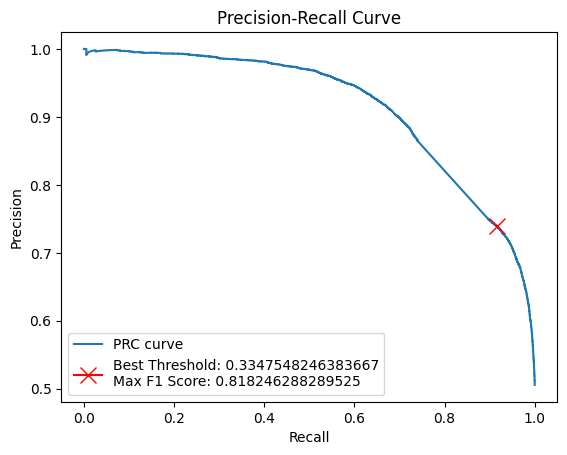

(0.9067664712792418, 0.7940330231473082, 0.33475482, 0.818246288289525)

In [66]:
attn_model = load_keras('model/attention.keras')
evaluate_deep_learning_model(attn_model, X_test, y_test)

### Model 6: Attention Model with Review Length

Since there was some correlation between review length and sentiment, we tried a model where the review length is included as an input. However, this lead to only a small improvement in performance, but much longer inference time.

In [67]:
def get_lengths(df_stemmed: pd.DataFrame, col_text: str, col_score: str) -> pd.DataFrame:
    frame = {
        'text_length': df_stemmed[col_text].apply(len),
        col_score: df_stemmed[col_score]
    }
    return pd.DataFrame(frame)

# df_stemmed = read_tokenized_csv('datasets/steam_200000_stemmed.csv', 'text')
# df_lengths = get_lengths(df_stemmed, 'text', 'score')
# df_to_csv(df_lengths, 'datasets/steam_200000_lengths.csv')

In [68]:
df_lengths = pd.read_csv('datasets/steam_200000_lengths.csv')
Length_train, Length_test, y_train, y_test = split_data(df_lengths, 'score')
Length_train, Length_test, y_train, y_test = convert_to_np(Length_train, Length_test, y_train, y_test)

In [69]:
def generate_attention_length_model(X_train, X_test, y_train, y_test,
                                    Length_train, Length_test, save_path, tokenizer,
                                    learning_rate=0.001, embedding_dim=100,
                                    units=100, batch_size=64, epochs=100, patience=3):

    from keras.models import Model
    from keras.layers import Embedding, LSTM, Input, Attention, Concatenate, Dense
    from keras.metrics import AUC
    from keras.callbacks import EarlyStopping, ModelCheckpoint
    from keras.optimizers import Adam

    vocab_size = len(tokenizer.word_index) + 1

    input_layer_text = Input(shape=(X_train.shape[1],))
    input_layer_length = Input(shape=(1,))

    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer_text)

    lstm_layer = LSTM(units, return_sequences=True)(embedding_layer)
    attention = Attention()([lstm_layer, lstm_layer])

    merged = Concatenate(axis=-1)([lstm_layer, attention])
    merged = LSTM(64)(merged)

    concatenated = Concatenate()([merged, input_layer_length])

    output_layer = Dense(1, activation='sigmoid')(concatenated)

    model = Model(inputs=[input_layer_text, input_layer_length], outputs=output_layer)

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=[AUC(curve="PR", name="pr_auc"), 'accuracy'])

    early_stopping = EarlyStopping(monitor='val_pr_auc', patience=patience, mode='max')

    model_save = ModelCheckpoint(save_path, save_best_only=True, monitor='val_pr_auc', mode='max')

    model.fit([X_train, Length_train], y_train, epochs=epochs, batch_size=batch_size, validation_data = ([X_test, Length_test], y_test), callbacks = [early_stopping, model_save])

    return model

# attn_len_model = generate_attention_length_model(X_train, X_test, y_train, y_test, Length_train, Length_test, 'model/attention_length.keras', tokenizer)

1206/1206 ━━━━━━━━━━━━━━━━━━━━ 36s 30ms/step


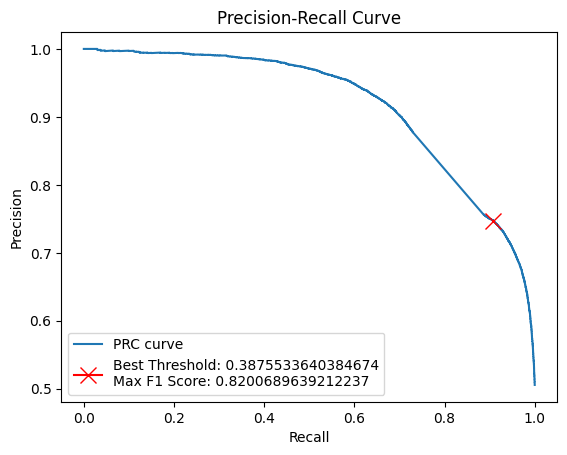

(0.9084483526223294, 0.7984395655667591, 0.38755336, 0.8200689639212237)

In [70]:
attn_len_model = load_keras('model/attention_length.keras')
evaluate_deep_learning_model(attn_len_model, [X_test, Length_test], y_test)

### Model 7: Transformer Architecture

The last model we tried is a transformer model. It relies solely on attention mechanism, eschewing recurrent or convolutional layers. Multi-head attention allows the model to focus on different parts of the input sequence simultaneously, with each head learning different relationships within the data, contributing to a more comprehensive understanding. Positional encodings are also added to input embeddings to provide positional information to the model.

In [71]:
def generate_transformer_model(X_train, X_test, y_train, y_test,
                               save_path, tokenizer, embedding_dim=100,
                               intermediate_dim=128, num_heads=4,
                               batch_size=64, epochs=100, patience=3):

    from keras.models import Model
    from keras.layers import Embedding, Input, Dense, GlobalAveragePooling1D
    from keras_nlp.layers import TransformerEncoder
    from keras.metrics import AUC
    from keras.callbacks import EarlyStopping, ModelCheckpoint

    vocab_size = len(tokenizer.word_index) + 1

    input_layer = Input(shape=(X_train.shape[1],))
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)

    transformer_layer = TransformerEncoder(intermediate_dim=intermediate_dim, num_heads=num_heads)(embedding_layer)
    pooling_layer = GlobalAveragePooling1D()(transformer_layer)

    output_layer = Dense(1, activation='sigmoid')(pooling_layer)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(curve="PR", name="pr_auc"), 'accuracy'])

    early_stopping = EarlyStopping(monitor='val_pr_auc', patience=patience, mode='max')

    model_save = ModelCheckpoint(save_path, save_best_only=True, monitor='val_pr_auc', mode='max')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data = (X_test, y_test), callbacks = [early_stopping, model_save])

    return model

# transformer_model = generate_transformer_model(X_train, X_test, y_train, y_test, 'model/transformer.keras', tokenizer)

1206/1206 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step


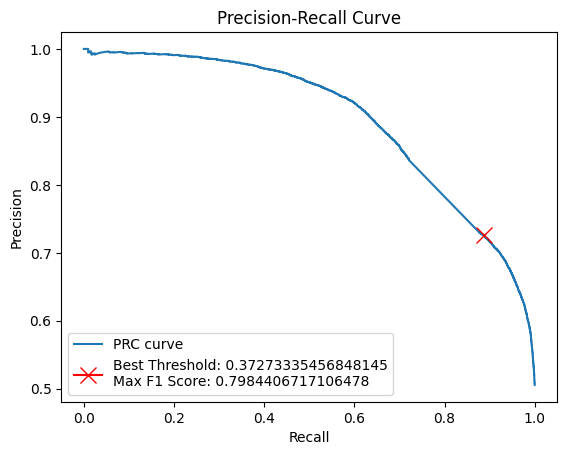

(0.8888269767547661, 0.7734777988024573, 0.37273335, 0.7984406717106478)

In [72]:
transformer_model = load_keras('model/transformer.keras')
evaluate_deep_learning_model(transformer_model, X_test, y_test)

# Results and Insights
    


## Non-Deep Learning Models (F1-Score)

| Model         | TF-IDF    | Word2Vec  |
|---------------|-----------|-----------|
| Decision Tree | 0.654     | 0.629     |
| Random Forest | 0.736     | 0.729     |
| Linear SVC    | 0.741     | 0.732     |
| Naive Bayes   | 0.731     | 0.589     |
| AdaBoost      | 0.738     | 0.712     |
| XGBoost       | **0.743** | **0.743** |

## Deep Learning Models (AUC-PRC)

| Model           | Tf-idf    | Word2vec  |
|-----------------|-----------|-----------|
| Sequential      | 0.865     | 0.872     |
| Dense           | 0.819     | 0.873     |
| Dense + Dropout | **0.872** | **0.877** |
| CNN             | 0.870     | 0.870     |
| Bidirectional   | 0.865     | 0.875     |

| Model              | AUC-PRC   |
|--------------------|-----------|
| Attention          | 0.907     |
| Attention + Length | **0.908** |
| Transformer        | 0.888     |

## Best Performaning Models:
### Non-Deep Learning:
  - Tf-idf: SVC: 0.741
  - W2V: XGBoost: 0.742

### Deep Learning:
  - Attention Model with Review Length: 0.908
  - Attention Model: 0.907
  - TF-idf: Dense + Dropout: 0.871
  - W2V: Dense + Dropout: 0.876

## Insights

* Characteristics of dataset - Steam Reviews:
  - Reviews of online video games
  - Sarcasm in reviews
  - Game-specific terminology
  - Temporal changes in data

* Word2Vec embeddings based models perform better on average to Tf-idf based models:
  - W2V captures semantic relationships and context similarities, whilst Tf-idf only captures word frequency
  - In more vocabulary-specific datasets like Steam reviews, semantic information is important.

* However, for non-deep learning models, Tf-idf models performed slightly better
  - In dataasets with noise, Tf-idf might perform better for traditional models such as SVM and decision tree.
  - This corroborates with our findings, especially for Naiyes Bayes and SVC

* Attention Model VS Dense + Dropout:
  - Handling of sequential information is not done in the Dense + dropout model, that is it doesn't consider the existence of sequencing in text data. Given the characteristics of the dataset, this is an important feature.
  - Attention Model includes the additional feature review length, which helps the model account for more complexity and thus provide more regularization to prevent overfitting. Also allows for dynamic focus, and consider hierarchal relationships.

* Overall Deep-Learning performed better than non-deep learning models:
  - Deep-Learning models can capture non-linear relationships between features and target labels. More semantic understanding, rather than non-deep learning models which are based more on statistical methods.


  

# Deployment

The 2 final models we decided to use are:

1. Dense + Dropout Model (W2V)

    This is relatively simple model and provides decent performance. It provides a good balance between inference time and good predictions.

2. Attention Model (Without review length)
    
    More robust but longer inference time. Although the attention model with review length performs slightly better, we decided that the much longer inference time was not a good trade off.

In [73]:
def clean_and_stem(data: pd.DataFrame, col_text: str) -> pd.Series:

    def clean(text: str):
        from nltk.tokenize import word_tokenize
        import string
        text = text.lower()
        text = ''.join([word if (word not in string.punctuation or word.isascii()) else ' ' for word in text])
        tokens = word_tokenize(text)
        return tokens

    def stem(tokens):
        from nltk.stem import PorterStemmer
        stemmer = PorterStemmer()
        return [stemmer.stem(token) for token in tokens]

    return data[col_text].astype(str).apply(clean).apply(stem)

In [74]:
def w2v_transform(stemmed: pd.Series, w2v_model_path: str) -> np.ndarray:

    from gensim.models import Word2Vec
    word_embedding_model = Word2Vec.load(w2v_model_path)

    vector_size = word_embedding_model.vector_size
    apply_word_embedding = lambda x: [word_embedding_model.wv[word] for word in x if word in word_embedding_model.wv]
    apply_mean = lambda x: np.mean(x, axis=0) if len(x) > 0 else np.zeros(vector_size)
    vectors = stemmed.apply(apply_word_embedding).apply(apply_mean).to_list()
    transformed = pd.DataFrame(vectors, columns=list(range(vector_size))).to_numpy()

    return transformed

In [75]:
def tokenize_transform(stemmed: pd.Series, tokenizer_path: str, maxlen: int) -> np.ndarray:

    text = stemmed.apply(' '.join).values

    import joblib
    tokenizer = joblib.load(tokenizer_path)
    sequences = tokenizer.texts_to_sequences(text)

    from keras.preprocessing.sequence import pad_sequences
    transformed = pad_sequences(sequences, maxlen=maxlen)

    return transformed

In [76]:
def predict(transformed: np.ndarray, model_path: str) -> np.ndarray:

    from keras.saving import load_model
    model = load_model(model_path)

    return model.predict(transformed)

In [77]:
def dd_predict(file_path: str, col_text: str, new_pred_col: str) -> pd.DataFrame:
    data = pd.read_csv(file_path)
    stemmed = clean_and_stem(data, col_text)
    transformed = w2v_transform(stemmed, 'datasets/word_embedding_model')
    pred = predict(transformed, 'model/densedropout_w2v_tuned.keras')
    data[new_pred_col] = pred
    return data

# dd_predicted = dd_predict('datasets/steam_dataset_200000.csv', 'review_text', 'pred_score')
# df_to_csv(dd_predicted, 'datasets/steam_dd_predicted.csv')

In [78]:
def attn_predict(file_path: str, col_text: str, new_pred_col: str) -> pd.DataFrame:
    data = pd.read_csv(file_path)
    stemmed = clean_and_stem(data, col_text)
    transformed = tokenize_transform(stemmed, 'datasets/tokenizer.pkl', 70)
    pred = predict(transformed, 'model/attention.keras')
    data[new_pred_col] = pred
    return data

# attn_predicted = attn_predict('datasets/steam_dataset_200000.csv', 'review_text', 'pred_score')
# df_to_csv(attn_predicted, 'datasets/steam_attn_predicted.csv')

In [79]:
dd_predicted = pd.read_csv('datasets/steam_dd_predicted.csv')
attn_predicted = pd.read_csv('datasets/steam_attn_predicted.csv')

## Application: Twitter Recommends

We developed application using our models, specifically a tweet-based recommendation system. By gathering sentiments on the latest tweets about any game, and aggregating it's sentiment score, we then tell the user if they should play that game. Here are the steps to set it up:



Ensure you are using Python 3.10.11

1. git clone https://huggingface.co/spaces/vnnamng/Sentimentalyst
2. Go inside the folder
3. pip install -r requirements.txt
4. [Optional] There might be a need for install tenserflow-intel.
5. Set up a .env  which is your twitter account:

Example:

```
USERNAME_TWT = "username"
PASSWORD_TWT = "password"
EMAIL_TWT = "email@email.com"
PASSWORD_EMAIL_TWT = "_"
```

Password_email is not required, put as _

6. python app.py
7. Use the app as per normal

# Error Analysis

In this section, we examine errors made by the model. By doing this, we can identify patterns that the model struggle with, providing insights into the specific cases where the model fails to generalize well. We categorise these errors as false positives and false negatives.

In [80]:
def error_analysis(data: pd.DataFrame,
                   col_text: str,
                   col_score: str,
                   col_pred: str,
                   threshold: float) -> tuple[np.ndarray, np.ndarray]:

    from numpy import logical_and, logical_not

    text_pred = data[[col_text, col_pred]].to_numpy()
    true_score = data[col_score].to_numpy() > 0
    predicted_label = data[col_pred].to_numpy() > threshold

    false_positives = logical_and(logical_not(true_score), predicted_label)
    false_negatives = logical_and(true_score, logical_not(predicted_label))

    false_positives = text_pred[false_positives]
    false_negatives = text_pred[false_negatives]

    return false_positives, false_negatives

dd_false_positives, dd_false_negatives = error_analysis(dd_predicted, 'review_text', 'review_score', 'pred_score', 0.3923902)
attn_false_positives, attn_false_negatives = error_analysis(attn_predicted, 'review_text', 'review_score', 'pred_score', 0.33475482)

In [81]:
def error_breakdown(false_positives: np.ndarray, false_negatives: np.ndarray):
    from matplotlib import pyplot as plt
    num_false_positives = len(false_positives)
    num_false_negatives = len(false_negatives)
    plt.figure(figsize=(8, 6))
    plt.bar(['False Positives', 'False Negatives'], [num_false_positives, num_false_negatives], color=['blue', 'red'])
    plt.title('Comparison of False Positives and False Negatives')
    plt.xlabel('Type of Error')
    plt.ylabel('Number of Errors')
    plt.show()

In [82]:
def visualize_word_cloud(false_positives: np.ndarray, false_negatives: np.ndarray):

    from matplotlib import pyplot as plt
    from wordcloud import WordCloud

    false_positives = ' '.join(false_positives[:, 0].astype('str'))
    false_negatives = ' '.join(false_negatives[:, 0].astype('str'))

    fp_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(false_positives)
    fn_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(false_negatives)

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(fp_wordcloud, interpolation='bilinear')
    plt.title('False Positives')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(fn_wordcloud, interpolation='bilinear')
    plt.title('False Negatives')
    plt.axis('off')

    plt.show()

In [83]:
def extreme_errors(false_positives: np.ndarray,
                   false_negatives: np.ndarray,
                   n: int) -> tuple[np.ndarray, np.ndarray]:
    false_positives = false_positives[false_positives[:, 1].argsort()][::-1][:n]
    false_negatives = false_negatives[false_negatives[:, 1].argsort()][:n]
    return false_positives, false_negatives

## Dense Dropout Model Errors

### Error Breakdown

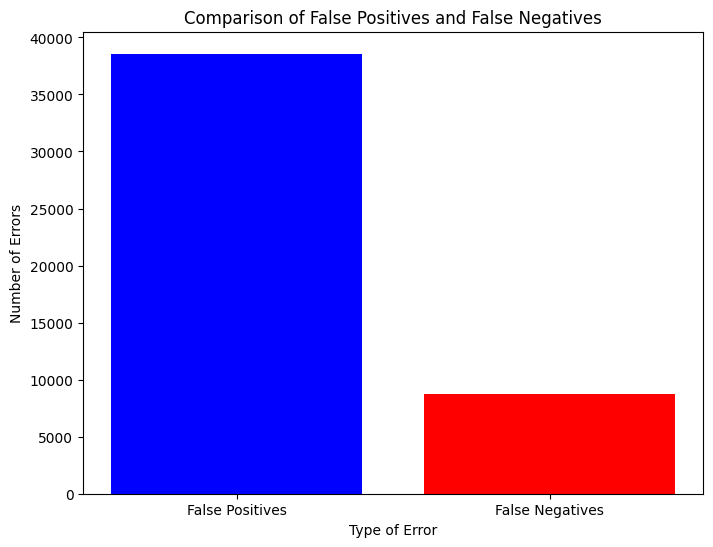

In [84]:
error_breakdown(dd_false_positives, dd_false_negatives)

### Most Common Words

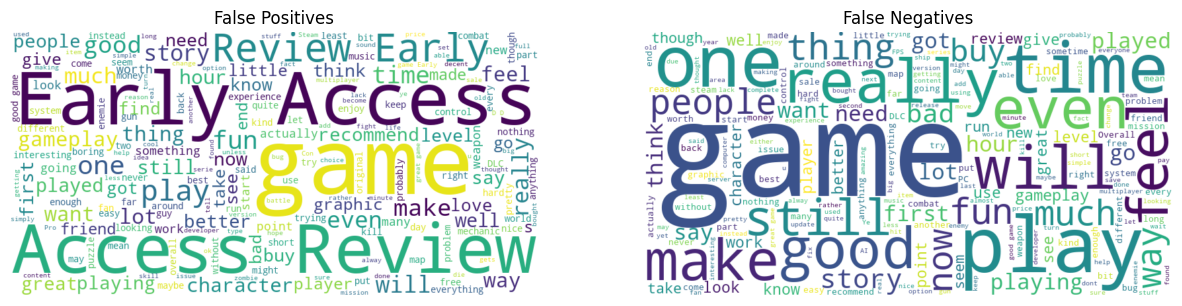

In [85]:
visualize_word_cloud(dd_false_positives, dd_false_negatives)

In [86]:
dd_extreme_fp, dd_extreme_fn = extreme_errors(dd_false_positives, dd_false_negatives, 20)

### Extreme False Positives

In [87]:
dd_extreme_fp

array([['An excellent WWI slideshow', 1.0],
       ['+ ', 1.0],
       ['Roblox with guns', 1.0],
       [' A Top-Down Action Survival Arena', 1.0],
       ['))', 0.99991375207901],
       ["it's great", 0.9996944665908812],
       ['Great game, I recommend it to everyone with a creative mind!',
        0.9993458986282348],
       [" 'Junk food addicted Lemur under heavy fire'",
        0.9992618560791016],
       ['   A Hardcore 2D Platformer', 0.999098002910614],
       ['pretty ♥♥♥♥ing shait', 0.9989668130874634],
       ['10/10', 0.9985047578811646],
       ['10/10', 0.9985047578811646],
       ['10/10', 0.9985047578811646],
       ['10/10', 0.9985047578811646],
       ["It's great.", 0.9981417059898376],
       ['Heavy breathing simulator 4/10', 0.9975568056106568],
       ['10/10 ♥♥♥♥', 0.9972930550575256],
       ['very fun and educational', 0.9962076544761658],
       ['great game', 0.9955700039863586],
       ['great game', 0.9955700039863586]], dtype=object)

### Extreme False Negatives

In [88]:
dd_extreme_fn

array([['Trash', 3.8413283665050807e-10],
       ['NOT WORKING', 4.206969350661893e-08],
       ['Reported', 4.66970823254087e-06],
       ['No bowling expansion pack No bowling DLC 0/10',
        1.871862150437664e-05],
       ['TOO REAL', 4.893565346719697e-05],
       ['They removed microtransactions we good again',
        6.136366573628038e-05],
       ['worst card game ever', 0.0010965581750497],
       ['Payday 2 Because Crime Does Pay', 0.0011186135234311],
       ['crashes', 0.0018024577293545],
       ['keeps crashing servers wont work please fix',
        0.0018780643586069],
       ['Just terrible', 0.0019391867099329],
       ['Lots of potential yet unfinished.', 0.0020292028784751],
       ['Boring', 0.0022879699245095],
       ['Cheat engine DLC.', 0.002331530675292],
       ['♥♥♥♥♥♥♥♥ly difficult no saving no windowed mode  indie dev    support indie dev 11/10',
        0.0023575355298817],
       ['Interesting tech demo. Not a game.', 0.005174899008125],
       ['Horri

## Attention Model Errors

## Error Breakdown

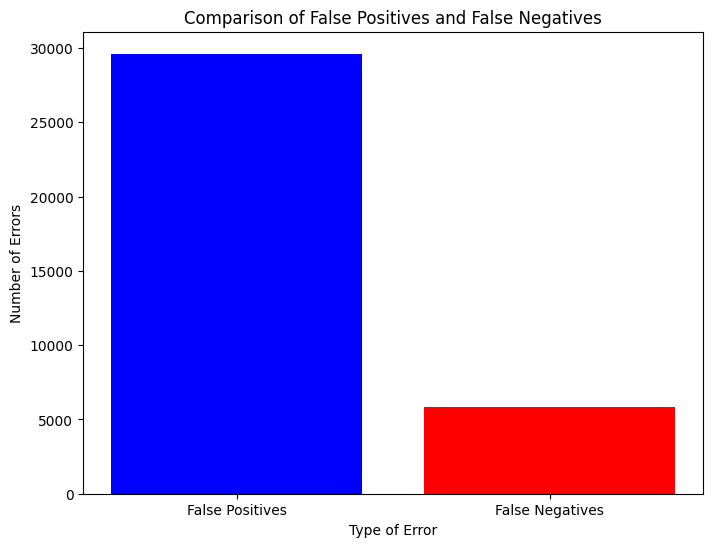

In [89]:
error_breakdown(attn_false_positives, attn_false_negatives)

### Most Common Words

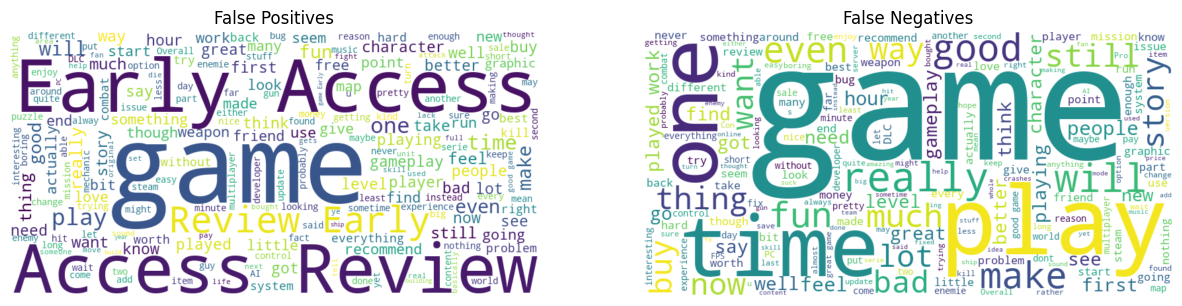

In [90]:
visualize_word_cloud(attn_false_positives, attn_false_negatives)

In [91]:
attn_extreme_fp, attn_extreme_fn = extreme_errors(attn_false_positives, attn_false_negatives, 20)

### Extreme False Positives

In [92]:
attn_extreme_fp

array([['face war is a game where you slide in a near post apocalyptic role play mission with zombies on early access.  the game comes with 900 dosh for your guns you need to buy to win so keep that in mind when you are playing and fighting the role playing zombies  make sure you slide into peoples stomachs while shooting your gun wildly like a bloody genius  can u survive the night with this game?  Ign: Like skyrim with guns! 11/10 PC Gamer: Mind Bowling 9/10 Gamespot: The best call of duty yet 10/10',
        0.9986364841461182],
       ['tHIS GAME IS GREAT. THE PEOPLE ARE SO NICE AND THE VISUALS ARE TOP NOTCH. 10/10',
        0.9983680844306946],
       ['This is a very good game with very fluid parkour mechanics, little to no RNG, and completley free to play with all warframes and accessories unlocked at start. Would recommened if you like getting boosted',
        0.9977613091468812],
       ["*EDIT (25/10/2016)* I do no longer recommend the game, as the game has lost a little ove

### Extreme False Negatives

In [93]:
attn_extreme_fn

array([['0% this game is broken. I followed directions 100% (been gaming for 30 years) and had to CTRL-ALT-DEL to get out. 100% fail, game is BROKEN, 100% do not recommend. Fail fail fail.',
        0.0016115690814331],
       ['Do not recommend.  This game ruins lives.   Horribly addicting.',
        0.0045407246798276],
       ["Iwas amazed by WHOS NEXT trailer so i prepurchased game for 50 euro's. Preloaded game, and waited till early morning for game to get unlocked so i can try it. 06:00h local time, game was finally unlocked. Ok, let's start it. I watched loading screens one after another, choose faction, and than i entered main menu. Not so bad, i was thinking. Few thing's like STORY mode or MP mode was locked, but, let us wait till it downloaded all of the files (but they not downloading at all). Let me try solo mode before i go to fc..king 8 hours working in some shity garage... OH.... game chrashed... I'll try to reboot my PC, it was on for like 10 years... Loading screen's e

## Insights

- False Positives: Both models struggle with understanding sarcasm. For example, there were users who sarcasticly reviewed the game as 'great game 10/10', while giving negative reviews. Both of our models incorrectly predict such reviews to be positive.

- False Negatives: Both models struggles less with false negatives as compared to false positives. The false negatives also seem to be largely due to data error, where the user's negative sentiment expressed in the review does not align with the positive score they submitted. Examples of this include 'worst game i ever bought, waste of money do not buy' and 'Trash'.

- Edited reviews are prone to being misclassified. For these reviews, the users could have possibly changed their opinion of the game after a while, while the content of their original review remains. This results in a mix of sentiments.

- Neutrality: Some reviews such as "Early Access Review" and do not express sentiment of the user. A prominent number of misclassifications arise from these neutral reviews.

# Other models


In this section, we explore how our models stack up against existing models.

## VaderSentiment

[VADER-Sentiment-Analysis](https://github.com/cjhutto/vaderSentiment) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

In [94]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Wrap function to read and edit CSV files
def process_csv_vader(df):

    # Initialize the SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()

    # Initialize lists to store data
    review_texts = []
    positive_scores = []
    negative_scores = []
    neutral_scores = []
    compound_scores = []

    # Perform sentiment analysis and store scores in lists
    for review in df['review_text']:
        review = str(review)
        vs = analyzer.polarity_scores(review)

        review_texts.append(review)
        pos, neg, neu = vs['pos'], vs['neg'], vs['neu']
        positive_scores.append(pos)
        negative_scores.append(neg)
        neutral_scores.append(neu)
        compound_scores.append(((pos - neg) + 1) / 2)

    # Add sentiment scores and NPS categories to the DataFrame

    result_df = df.copy()

    result_df['positive_scores'] = positive_scores
    result_df['negative_scores'] = negative_scores
    result_df['neutral_scores'] = neutral_scores
    result_df['compound_scores'] = compound_scores

    return(result_df)

# df = pd.read_csv('datasets/steam_dataset_200000.csv')
# # df = truncate(df, 'review_score', 2000)
# vader_df = process_csv_vader(df)
# df_to_csv(vader_df, 'datasets/steam_vader.csv')

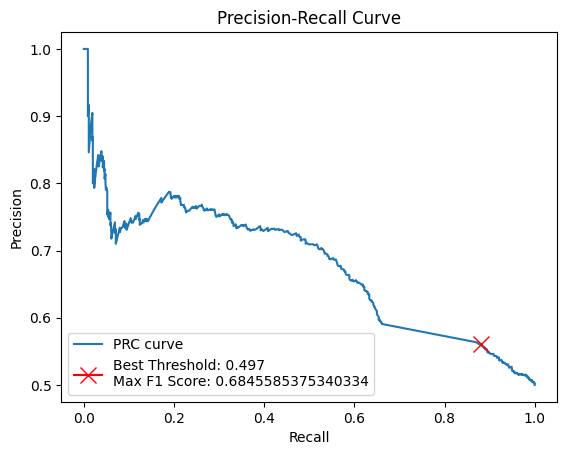

(0.6735058201503314, 0.5945, 0.497, 0.6845585375340334)

In [95]:
vader_df = pd.read_csv('datasets/steam_vader.csv')
metrics(vader_df['review_score'].replace(-1, 0).to_numpy(), vader_df['compound_scores'].to_numpy())

VADER performs poorly for our task. This could be because of its rule-based nature, relying on predefined lexicons and rules to determine sentiment polarity, intensity, and sentiment modifiers. It may struggle with more nuanced or context-dependent language found in gaming reviews.

## pysentimiento
[pysentimiento](https://github.com/pysentimiento/pysentimiento) is a Python toolkit for Sentiment Analysis and Social NLP tasks. The model supports multiple languages.

In [97]:
from pysentimiento import create_analyzer

def process_csv_pysentimento(df):

    # Initialize the SentimentIntensityAnalyzer
    analyzer = create_analyzer(task="sentiment", lang="en")

    # Initialize lists to store data
    review_texts = []
    positive_scores = []
    negative_scores = []
    neutral_scores = []
    compound_scores = []
    # Perform sentiment analysis and store scores in lists
    for review in df['review_text']:
        review = str(review)
        vs = analyzer.predict(review)
        review_texts.append(review)
        probas = vs.probas
        pos, neg, neu = probas['POS'], probas['NEG'], probas['NEU']
        positive_scores.append(pos)
        negative_scores.append(neg)
        neutral_scores.append(neu)
        compound_scores.append(((pos - neg) + 1) / 2)

    # Add sentiment scores and NPS categories to the DataFrame

    result_df = df.copy()

    result_df['positive_scores'] = positive_scores
    result_df['negative_scores'] = negative_scores
    result_df['neutral_scores'] = neutral_scores
    result_df['compound_scores'] = compound_scores

    return(result_df)
# Perform sentiment analysis on the Steam dataset
# df = pd.read_csv('datasets/steam_dataset_200000.csv')
# df = truncate(df, 'review_score', 2000)
# pysentimiento_df = process_csv_pysentimento(df)
# df_to_csv(pysentimiento_df, 'datasets/steam_pysentimiento.csv')

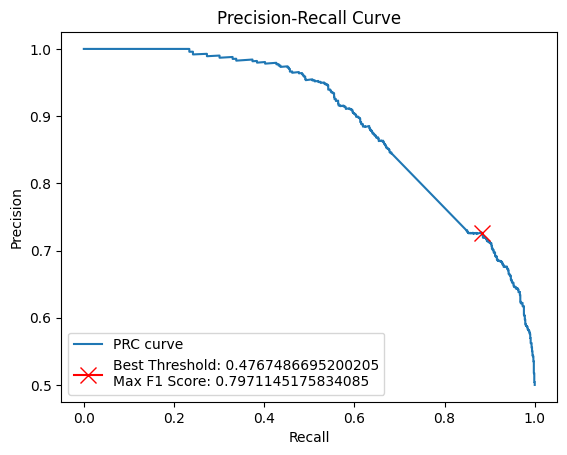

(0.8833024721772428, 0.7745, 0.4767486695200205, 0.7971145175834085)

In [98]:
pysentimiento_df = pd.read_csv('datasets/steam_pysentimiento.csv')
metrics(pysentimiento_df['review_score'].replace(-1, 0).to_numpy(), pysentimiento_df['compound_scores'].to_numpy())

pysentimiento performs quite well for our task. Its performance rivals our model in terms of AUC-PRC. Being a transformer model, it has a deeper understanding of semantics and context compared to rule-based systems as it can analyze the meaning of words and phrases in relation to their surrounding context. However, it has a very slow inference time.

# Next Steps

If we had more time to work on this project, here are a few things we would like to explore:

* Other pre-trained word embeddings

    * Explore other pre-trained word embedding models, such as GloVe.

* Pre-trained transformer models

    * Use pre-trained transformer models such as BERT or GPT and fine-tune it on our dataset.

* Domain specific features

    * Explore domain specific features such as user demographics, temporal information, and gameplay time and how they influence sentiment. With more contextual information, the model might struggle less with sarcasm.

* Neutral Scores

    * Rather than binary classificaiton, we realised that it might be useful to include a 'Neutral' class, as done by many sentiment analysis models. Many reviews simply do not have a clear sentiment and having a metric of how neutral a review is might decrease misclassifications and make the model more useful.

* Explainable AI

    * As our final models are deep learning models, we would like to explore methods to improve their explanability. We can use techniques such as feature importance scores, SHAP (SHapley Additive exPlanations), or LIME (Local Interpretable Model-agnostic Explanations) to understand the contribution of each input feature to the model's predictions.

